In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.model_selection import train_test_split
import os
import random
from tqdm import tqdm
from PIL import Image
import math
import json
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time
import torch.quantization
import torchvision.transforms.functional as TF
from sklearn.metrics import confusion_matrix
import seaborn as sns
import warnings
import pandas as pd

In [2]:
from google.colab import drive
drive.mount(('/content/drive'))

Mounted at /content/drive


In [3]:
%%time

import tarfile

path = "/content/drive/MyDrive/LaPa.tar.gz"
extract_path = "/tmp"

# Open the tar.gz file
with tarfile.open(path, "r:gz") as tar:
    # Extract all contents to /tmp
    tar.extractall(path=extract_path)

CPU times: user 19.3 s, sys: 11 s, total: 30.3 s
Wall time: 1min


In [4]:
# Define paths to the subfolders
train_path = os.path.join("/tmp/LaPa/train")
test_path = os.path.join("/tmp/LaPa/test")
validation_path = os.path.join("/tmp/LaPa/val")

# Define paths to the images subfolder in each dataset split
train_images_path = os.path.join(train_path, "images")
test_images_path = os.path.join(test_path, "images")
validation_images_path = os.path.join(validation_path, "images")

# List files in each subfolder in alphanumerical order
train_files = os.listdir(train_path)
test_files = os.listdir(test_path)
validation_files = os.listdir(validation_path)
train_files.sort()
test_files.sort()
validation_files.sort()

print("Train files:", train_files)
print("Test files:", test_files)
print("Validation files:", validation_files)
print("__________________________________________")

train_images = os.listdir(train_images_path)
test_images = os.listdir(test_images_path)
validation_images = os.listdir(validation_images_path)
train_images.sort()
test_images.sort()
validation_images.sort()

# print("Train images:", train_images)
# print("Test images:", test_images)
# print("Validation images:", validation_images)
# print("__________________________________________")

# Define paths to the landmarks subfolder in each dataset split
train_landmarks_path = os.path.join(train_path, "landmarks")
test_landmarks_path = os.path.join(test_path, "landmarks")
validation_landmarks_path = os.path.join(validation_path, "landmarks")

train_landmarks = os.listdir(train_landmarks_path)
test_landmarks = os.listdir(test_landmarks_path)
validation_landmarks = os.listdir(validation_landmarks_path)
test_landmarks.sort()

# print("Train landmarks:", train_landmarks)
# print("Test landmarks:", test_landmarks)
# print("Validation landmarks:", validation_landmarks)
# print("__________________________________________")

# Define paths to the labels subfolder in each dataset split
train_labels_path = os.path.join(train_path, "labels")
test_labels_path = os.path.join(test_path, "labels")
validation_labels_path = os.path.join(validation_path, "labels")

train_labels = os.listdir(train_labels_path)
test_labels = os.listdir(test_labels_path)
validation_labels = os.listdir(validation_labels_path)
test_labels.sort()

# print("Train labels:", train_labels[:1500])
# print("Test labels:", test_labels[:400])
# print("Validation labels:", validation_labels[:250])
# print("__________________________________________")


Train files: ['images', 'labels', 'landmarks']
Test files: ['images', 'labels', 'landmarks']
Validation files: ['images', 'labels', 'landmarks']
__________________________________________


In [5]:
# Save checkpoint
def save_checkpoint(state,epoch,filename='GANUNET.weights.pth.tar_'):
    print('Saving weights-->')
    torch.save(state,filename+str(epoch))

# Load checkpoint
def load_checkpoint(filename,generator, discriminator, g_optimizer, d_optimizer, device):
    print('Loading weights-->')
    checkpoint = torch.load(filename, map_location=device)
    #checkpoint = torch.load(filename)
    generator.state_dict(checkpoint["generator_state_dict"])
    discriminator.state_dict(checkpoint["discriminator_state_dict"])
    g_optimizer.state_dict(checkpoint["g_optimizer"])
    d_optimizer.state_dict(checkpoint["d_optimizer"])
    # Move the model and optimizer to the correct device
    generator.to(device)
    discriminator.to(device)
    for state in g_optimizer.state.values():
        if isinstance(state, torch.Tensor):
            state.data = state.data.to(device)
            if state._grad is not None:
                state._grad.data = state._grad.data.to(device)
    for state in d_optimizer.state.values():
        if isinstance(state, torch.Tensor):
            state.data = state.data.to(device)
            if state._grad is not None:
                state._grad.data = state._grad.data.to(device)



In [6]:
def generate_image_from_masks(mask,original_image):
    # custom_colors = np.array([
    # [53, 86, 145], #blu
    # [3, 152, 158], #verdognolo
    # [60, 90, 20], #verde scuro
    # [89, 139, 44], #verde chiaro
    # [177, 143, 207], #lilla scuro
    # [203, 190, 238], #lilla chiaro
    # [0, 95, 115], #petrolio
    # [231,106,75],  #rosso
    # # [249, 166, 32], #arancione chiaro
    # [233, 196, 106], #giallo
    # [240, 128, 60], #arancione scuro
    # [132, 172, 206], #celestino
    #  ])
    custom_colors = plt.cm.get_cmap('tab20', num_masks)
    h, w = mask.shape
    rgb_image = np.zeros((h, w, 3), dtype=np.uint8)

    for y in range(h):
        for x in range(w):
            class_value = mask[y, x]
            color = custom_colors(class_value)[:3]
            color = (np.array(color) * 255).astype(np.uint8)  # Convert to 0-255 range
            rgb_image[y, x] = color
    return rgb_image

def normalise_image(image): # not used currently, lets add based on performance
    # perform mean and std deviation normalization
    mean = np.mean(image)
    std = np.std(image)
    normalized_image = (image - mean) / std
    return normalized_image

In [7]:
# Data Visualization
i = 22
image_path = train_images_path + "/" + os.listdir(train_images_path)[i]
mask_path = (train_labels_path + "/" + os.listdir(train_images_path)[i]).partition(".")[0] + ".png"

image_bgr = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
image_rgb = cv2.resize(image_rgb, (512, 512))
mask_img = cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)
# mask_img = cv2.resize(mask_img, (512, 512))
# mask_img = generate_image_from_masks(mask_img,image_rgb)

print(image_bgr.shape)
print(mask_img.shape)

(452, 468, 3)
(452, 468)


<ipython-input-6-2b4336fcfe78>:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  custom_colors = plt.cm.get_cmap('tab20', num_masks)


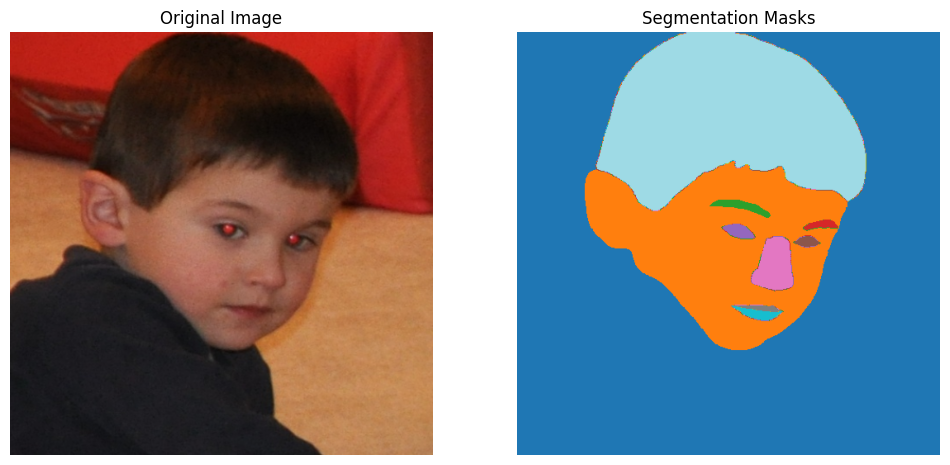

In [8]:
num_masks=11
# Data Visualization
i = 70
image_path = train_images_path + "/" + os.listdir(train_images_path)[i]
mask_path = (train_labels_path + "/" + os.listdir(train_images_path)[i]).partition(".")[0] + ".png"

image_bgr = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
image_rgb = cv2.resize(image_rgb, (512, 512))
mask_img = cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)
mask_img = cv2.resize(mask_img, (512, 512))
mask_img = generate_image_from_masks(mask_img,image_rgb)

# Display original and mask images side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # Create a figure with two subplots
axes[0].imshow(image_rgb)  # Display original image
axes[0].set_title('Original Image')
axes[0].axis('off')  # Hide axis
axes[1].imshow(mask_img)  # Display composite image with masks
axes[1].set_title('Segmentation Masks')
axes[1].axis('off')  # Hide axis
plt.show()

# LAPA + transform

In [5]:
def my_img_mask_transforms(image, mask):
    resize = transforms.Resize((512, 512))
    totensor = transforms.ToTensor()
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    image = resize(image)
    mask = resize(mask)

    seed = 2024
    random.seed(seed)
    torch.manual_seed(seed)

    if random.random() > 0.5:
          angle = random.randint(-30, 30)
          image = TF.rotate(image, angle)
          mask = TF.rotate(mask, angle)

    if random.random() > 0.5:
        image = TF.hflip(image)
        mask = TF.hflip(mask)

    # if random.random() > 0.5:
    #     image = TF.vflip(image)
    #     mask = TF.vflip(mask)

    image = totensor(image)
    image = normalize(image)
    mask = torch.tensor(np.array(mask), dtype=torch.float32)

    return image, mask



class Lapa(Dataset):
    def __init__(self, images_dir, masks_dir, size):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.image_files = os.listdir(images_dir)[:size]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        img_path = os.path.join(self.images_dir, self.image_files[index])
        mask_path = img_path.replace("images", "labels").replace("jpg", "png")

        # Open image
        original_image = Image.open(img_path).convert("RGB")

        # Open mask and convert to PIL Image
        mask_img = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask_img = Image.fromarray(cv2.resize(mask_img, (512, 512)))


        image, mask_img = my_img_mask_transforms(original_image, mask_img)
        original_image = transforms.Resize((512, 512))(original_image)
        original_image = transforms.ToTensor()(original_image)

        # Split the masks
        binary_masks = []
        for class_value in range(0, 11):
            binary_mask = (mask_img == class_value).float()
            binary_masks.append(binary_mask)

        return original_image, image, torch.stack(binary_masks, dim=0)

In [6]:
train_dataset = Lapa(train_images_path,
                    train_labels_path,
                    1200)

val_dataset = Lapa(validation_images_path,
                   validation_labels_path,
                   210)

test_dataset = Lapa(test_images_path,
                   test_labels_path,
                   210)


Image 0 is tensor: True


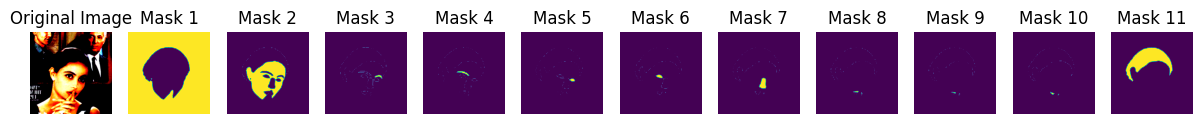

Image 1 is tensor: True


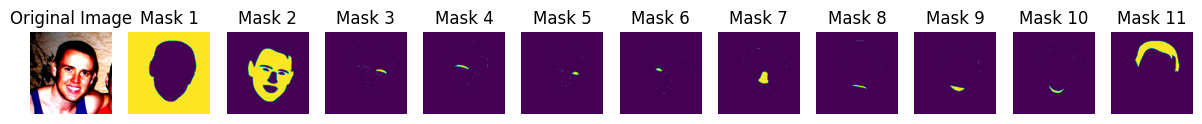

Image 2 is tensor: True


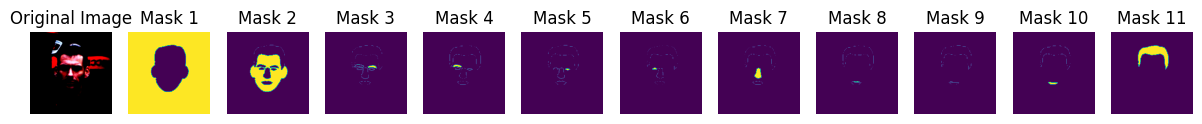

Image 3 is tensor: True


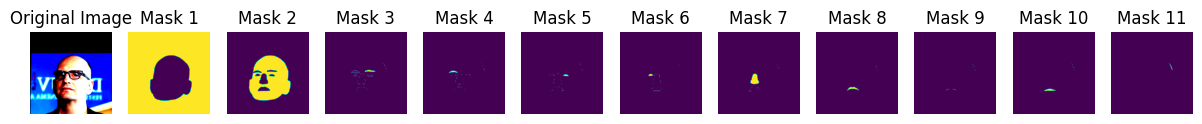

Image 4 is tensor: True


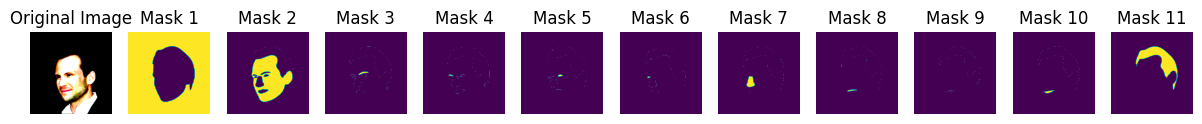

In [11]:
for i in range(5):  # Change the range as needed
    t = train_dataset[i]
    img = np.array(t[1].permute(1, 2, 0))
    print(f"Image {i} is tensor: {isinstance(t[1], torch.Tensor)}")
    mask = np.array(t[2])

    num_masks = mask.shape[0]
    fig, axes = plt.subplots(1, num_masks + 1, figsize=(15, 15))

    # Display the original image
    axes[0].imshow(img)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    # Display each mask
    for m in range(num_masks):
        axes[m + 1].imshow(mask[m])
        axes[m + 1].set_title(f'Mask {m + 1}')
        axes[m + 1].axis('off')

    plt.show()

# Train/Val loader - train_loop - test_loop

In [7]:
batch_size = 2
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [8]:
def print_masks_batch0(image, mask, pred, num_masks, epoch, batch, save_dir="/content/drive/MyDrive/masks_batch0"):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        num_masks = 11
        fig, axes = plt.subplots(1, num_masks, figsize=(15, 15))
        fig1, axes1 = plt.subplots(1, num_masks, figsize=(15, 15))
        fig2, axes2 = plt.subplots(1, 3, figsize=(12, 4))

        # Display each mask
        for m in range(num_masks):
            axes[m].imshow(mask[0][m].cpu())
            axes[m].set_title(f'Mask {m + 1}')
            axes[m].axis('off')

        for m in range(num_masks):
            axes1[m].imshow(pred[0][m].detach().cpu().numpy())
            axes1[m].set_title(f'PredMask {m + 1}')
            axes1[m].axis('off')

        colors = plt.cm.get_cmap('tab20', num_masks)  # Use a colormap with 20 colors
        # Create combined masks with different colors
        combined_mask = np.zeros((512, 512, 3))
        combined_pred = np.zeros((512, 512, 3))

        for m in range(num_masks):
            color = colors(m)[:3]  # Get RGB values from colormap
            combined_mask += np.stack([mask[0, m].cpu().numpy()] * 3, axis=-1) * color
            combined_pred += np.stack([pred[0, m].detach().cpu().numpy()] * 3, axis=-1) * color

        axes2[0].imshow(np.array(image[0].permute(1, 2, 0).cpu()))
        axes2[0].set_title('Image')
        axes2[0].axis('off')

        axes2[1].imshow(combined_mask)
        axes2[1].set_title('Combined Ground Truth Masks')
        axes2[1].axis('off')

        axes2[2].imshow(combined_pred)
        axes2[2].set_title('Combined Predicted Masks')
        axes2[2].axis('off')

        # Save the figures
        fig.savefig(f'{save_dir}/GANUNET_0masks_epoch{epoch}_batch{batch}.png')
        fig1.savefig(f'{save_dir}/GANUNET_0pred_masks_epoch{epoch}_batch{batch}.png')
        fig2.savefig(f'{save_dir}/GANUNET_0combined_masks_epoch{epoch}_batch{batch}.png')

        plt.show()
        plt.close(fig)
        plt.close(fig1)
        plt.close(fig2)

In [9]:
def print_masks_batch1(image, mask, pred, num_masks, epoch, batch, save_dir="/content/drive/MyDrive/masks_batch1"):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        num_masks = 11
        fig, axes = plt.subplots(1, num_masks, figsize=(15, 15))
        fig1, axes1 = plt.subplots(1, num_masks, figsize=(15, 15))
        fig2, axes2 = plt.subplots(1, 3, figsize=(12, 4))

        # Display each mask
        for m in range(num_masks):
            axes[m].imshow(mask[1][m].cpu())
            axes[m].set_title(f'Mask {m + 1}')
            axes[m].axis('off')

        for m in range(num_masks):
            axes1[m].imshow(pred[1][m].detach().cpu().numpy())
            axes1[m].set_title(f'PredMask {m + 1}')
            axes1[m].axis('off')

        colors = plt.cm.get_cmap('tab20', num_masks)  # Use a colormap with 20 colors
        # Create combined masks with different colors
        combined_mask = np.zeros((512, 512, 3))
        combined_pred = np.zeros((512, 512, 3))

        for m in range(num_masks):
            color = colors(m)[:3]  # Get RGB values from colormap
            combined_mask += np.stack([mask[1, m].cpu().numpy()] * 3, axis=-1) * color
            combined_pred += np.stack([pred[1, m].detach().cpu().numpy()] * 3, axis=-1) * color

        axes2[0].imshow(np.array(image[1].permute(1, 2, 0).cpu()))
        axes2[0].set_title('Image')
        axes2[0].axis('off')

        axes2[1].imshow(combined_mask)
        axes2[1].set_title('Combined Ground Truth Masks')
        axes2[1].axis('off')

        axes2[2].imshow(combined_pred)
        axes2[2].set_title('Combined Predicted Masks')
        axes2[2].axis('off')

        # Save the figures
        fig.savefig(f'{save_dir}/GANUNET_1masks_epoch{epoch}_batch{batch}.png')
        fig1.savefig(f'{save_dir}/GANUNET_1pred_masks_epoch{epoch}_batch{batch}.png')
        fig2.savefig(f'{save_dir}/GANUNET_1combined_masks_epoch{epoch}_batch{batch}.png')

        plt.show()
        plt.close(fig)
        plt.close(fig1)
        plt.close(fig2)


In [10]:
def compute_batch_metrics(pred_masks, true_masks, threshold=0.5):
    pred_masks = (pred_masks > threshold).int()
    #pred_masks = pred_masks.int()
    true_masks = true_masks.int()

    intersection = (pred_masks & true_masks).float().sum(dim=[2, 3])
    union = (pred_masks | true_masks).float().sum(dim=[2, 3])
    iou = intersection / (union + 1e-16)
    dice = 2 * intersection / (pred_masks.float().sum(dim=[2, 3]) + true_masks.float().sum(dim=[2, 3]) + 1e-16)

    mean_iou = iou.mean().item()
    mean_dice = dice.mean().item()

    return mean_iou, mean_dice

In [11]:
def train_loop(generator, discriminator, train_dataloader,val_dataloader, g_criterion, d_criterion, g_optimizer, d_optimizer,device, num_epochs):
  g_losses = []
  d_losses = []
  combined_losses = []

  val_g_losses = []

  train_iou = []
  train_dice = []
  val_iou = []
  val_dice = []

  no_improve_count = 0
  min_loss = None
  df = pd.DataFrame()
  df_checkpoint = pd.DataFrame()

  generator.to(device)
  discriminator.to(device)


  for epoch in range(num_epochs):
      generator.train()
      discriminator.train()
      loop = tqdm(enumerate(train_dataloader), total=len(train_dataloader), leave=True)
      ge_loss=0.
      de_loss=0.
      total_train_dice = 0
      total_train_iou = 0
      start = time.time()
      # bar = IncrementalBar(f'[Epoch {epoch+1}/{args.epochs}]', max=len(dataloader))
      for batch, (x_orig, x, real) in loop:
          x = x.to(device)
          real = real.to(device)

          # Generator`s loss
          fake = generator(x)
          fake_pred = discriminator(fake, x)
          g_loss = g_criterion(fake, real, fake_pred)

          # Discriminator`s loss
          fake = generator(x).detach()
          fake_pred = discriminator(fake, x)
          real_pred = discriminator(real, x)
          d_loss = d_criterion(fake_pred, real_pred)

          # Generator`s params update
          g_optimizer.zero_grad()
          g_loss.backward()
          g_optimizer.step()
          g_scheduler.step()

          # Discriminator`s params update
          d_optimizer.zero_grad()
          d_loss.backward()
          d_optimizer.step()
          # add batch losses
          ge_loss += g_loss.item()
          de_loss += d_loss.item()

          batch_iou, batch_dice = compute_batch_metrics(fake, real)
          total_train_dice += batch_dice
          total_train_iou += batch_iou

          # Update TQDM progress bar
      loop.set_description(f"Epoch [{epoch+1}/{num_epochs}] ")
      loop.set_postfix({'G_loss': ge_loss, 'D_loss': de_loss})
          # loop.set_postfix(loss=loss.detach().item())



      # obtain per epoch losses
      g_loss = ge_loss/len(train_dataloader)
      d_loss = de_loss/len(train_dataloader)
      g_losses.append(g_loss)
      d_losses.append(d_loss)
      avg_dice = total_train_dice/len(train_dataloader)
      avg_iou = total_train_iou/len(train_dataloader)
      train_dice.append(avg_dice)
      train_iou.append(avg_iou)



      # Validation metrics
      val_avg_g_loss, val_avg_dice, val_avg_iou = validate(generator, discriminator, val_dataloader, g_criterion, epoch, device)
      print(f"Validation Generator Loss: {val_avg_g_loss:.4f}, Validation Dice Coefficient: {val_avg_dice:.4f}, Validation mIoU: {val_avg_iou:.4f}")

      val_g_losses.append(val_avg_g_loss)
      val_iou.append(val_avg_iou)
      val_dice.append(val_avg_dice)



      checkpoint = {'generator_state_dict': generator.state_dict(), 'discriminator_state_dict': discriminator.state_dict(), 'g_optimizer': g_optimizer.state_dict(), 'd_optimizer': d_optimizer.state_dict()}


      data = {
        "epoch": [epoch+1],
        "train_g_loss": [g_loss],
        "train_d_loss": [d_loss],
        "val_g_loss": [val_avg_g_loss],
        "train_iou": [avg_iou],
        "train_dice": [avg_dice],
        "val_iou": [val_avg_iou],
        "val_dice": [val_avg_dice]
        }
      new_row = pd.DataFrame(data)
      df = pd.concat([df,new_row], ignore_index=True)
      df.to_csv("/content/drive/MyDrive/GANUNET_df_epochs")

      checkpoint_new_row = pd.DataFrame(checkpoint)
      df_checkpoint = pd.concat([df_checkpoint,checkpoint_new_row], ignore_index=True)
      df_checkpoint.to_csv("/content/drive/MyDrive/GANUNET_checkpoint_epochs")

      combined_loss = abs(g_loss) + abs(d_loss)
      combined_losses.append(combined_loss)
      if min_loss == None:
        min_loss = combined_loss
        save_checkpoint(checkpoint, epoch)
        no_improve_count = 0
      elif combined_loss < min_loss:
        min_loss = combined_loss
        save_checkpoint(checkpoint, epoch)
        no_improve_count = 0
      else:
        no_improve_count += 1

      if no_improve_count >= 3:
        print(f"Early stopping at epoch {epoch + 1}")
        break

      '''
      if (ge_loss == None) and (de_loss = None):
        min_loss = moving_loss
        save_checkpoint(checkpoint)
      elif moving_loss < min_loss:
        min_loss = moving_loss
        save_checkpoint(checkpoint)
      '''
      # count timeframe
      end = time.time()
      tm = (end - start)
      print("[Epoch %d/%d] [G loss: %.3f] [D loss: %.3f] ETA: %.3fs" % (epoch+1, num_epochs, g_loss, d_loss, tm))
  return g_losses, d_losses, combined_losses, val_g_losses, train_dice, train_iou, val_dice, val_iou

def validate(generator, discriminator, val_dataloader, g_criterion,epoch, device):
    generator.eval()
    generator.to(device)
    discriminator.eval()
    discriminator.to(device)
    total_val_dice = 0
    total_val_iou = 0
    val_g_loss = 0.0

    loop = tqdm(enumerate(val_dataloader), total=len(val_dataloader), leave=True)
    with torch.no_grad():
        for batch, (orig_val_x, val_x, val_real) in loop:
            val_x = val_x.to(device)
            val_real = val_real.to(device)

            val_fake = generator(val_x)

            # Calculate validation generator loss
            val_fake_pred = discriminator(val_fake, val_x)
            g_loss = g_criterion(val_fake, val_real, val_fake_pred)
            val_g_loss += g_loss.item()

            iou, dice = compute_batch_metrics(val_fake, val_real)
            total_val_dice += dice
            total_val_iou += iou

            # Update TQDM progress bar
            loop.set_postfix(loss=g_loss.item())

    print_masks_batch0(val_x, val_real, val_fake, 11, epoch, batch)
    print_masks_batch1(val_x, val_real, val_fake, 11, epoch, batch)

    avg_g_loss = val_g_loss / len(val_dataloader)
    avg_g_loss = val_g_loss / len(val_dataloader)
    avg_dice = total_val_dice / len(val_dataloader)
    avg_iou = total_val_iou / len(val_dataloader)

    return avg_g_loss, avg_dice, avg_iou

In [12]:
def print_test(original_image, image,mask,pred,num_masks):
  for i in [0,1]:
      num_masks = 11
      fig, axes = plt.subplots(1, num_masks, figsize=(15, 15))
      fig1, axes1 = plt.subplots(1, num_masks, figsize=(15, 15))
      fig2, axes2 = plt.subplots(1,4,figsize=(16,4))

      # Display each mask
      for m in range(num_masks):
          axes[m].imshow(mask[i][m].cpu())
          axes[m].set_title(f'Mask {m + 1}')
          axes[m].axis('off')

      for m in range(num_masks):
          axes1[m].imshow(pred[i][m].detach().cpu().numpy())
          axes1[m].set_title(f'PredMask {m + 1}')
          axes1[m].axis('off')


      colors = plt.cm.get_cmap('tab20', num_masks)  # Use a colormap with 20 colors

      # Create combined masks with different colors
      combined_mask = np.zeros((512, 512, 3))
      combined_pred = np.zeros((512, 512, 3))
      combined_binary_pred = np.zeros((512, 512, 3))

      for m in range(num_masks):
          color = colors(m)[:3]  # Get RGB values from colormap
          combined_mask += np.stack([mask[i, m].cpu().numpy()] * 3, axis=-1) * color
          combined_pred += np.stack([pred[i, m].detach().cpu().numpy()] * 3, axis=-1) * color


      axes2[0].imshow(np.array(original_image[i].permute(1, 2, 0).cpu()))
      axes2[0].set_title('Original Image')
      axes2[0].axis('off')

      axes2[1].imshow(np.array(image[i].permute(1,2,0).cpu()))
      axes2[1].set_title('Augmented Image')
      axes2[1].axis('off')

      axes2[2].imshow(combined_mask)
      axes2[2].set_title('Combined Ground Truth Masks')
      axes2[2].axis('off')

      axes2[3].imshow(combined_pred)
      axes2[3].set_title('Combined Predicted Masks')
      axes2[3].axis('off')
  plt.show()
  plt.close(fig)
  plt.close(fig1)
  plt.close(fig2)

In [13]:
from sklearn.metrics import accuracy_score

In [19]:
def test_loop(generator, test_dataloader, loss_fun, device, num_masks):
    generator.to(device)
    generator.eval()
    total_loss = 0.0
    total_iou = 0.0
    total_dice = 0.0
    num_batches = 0
    accuracy = 0.0

    # Initialize confusion matrix
    cm = np.zeros((num_masks, num_masks), dtype=int)

    loop = tqdm(enumerate(test_dataloader), total=len(test_dataloader), leave=True)
    with torch.no_grad():
        for batch, (orig_x, x, y) in loop:
            # Move data to device
            x = x.to(device)
            y = y.to(device)

            # Forward pass through the generator
            y_pred = generator(x)

            # Print the masks
            print_test(orig_x, x, y, y_pred, num_masks)

            # Calculate test loss
            loss = loss_fun(y_pred, y)
            total_loss += loss.item()

            # Compute metrics for the batch
            batch_iou, batch_dice = compute_batch_metrics(y_pred, y)
            total_iou += batch_iou
            total_dice += batch_dice

            # Flatten the masks and update confusion matrix
            y_flat = y.argmax(dim=1).view(-1).cpu().numpy()
            y_pred_flat = y_pred.argmax(dim=1).view(-1).cpu().numpy()

            accuracy += accuracy_score(y_flat, y_pred_flat)

            if y_flat.shape[0] != y_pred_flat.shape[0]:
                print(f"Shape mismatch: y_flat {y_flat.shape}, y_pred_flat {y_pred_flat.shape}")
                continue

            cm += confusion_matrix(y_flat, y_pred_flat, labels=np.arange(num_masks))

            num_batches += 1

            # Update TQDM progress bar
            loop.set_postfix(loss=loss.item())

    avg_loss = total_loss / num_batches
    avg_iou = total_iou / num_batches
    avg_dice = total_dice / num_batches
    avg_accuracy = accuracy / num_batches

    print("")
    print(f'Test Loss: {avg_loss:.4f}')
    print(f'Mean IoU: {avg_iou:.4f}')
    print(f'Mean Dice: {avg_dice:.4f}')
    print(f'Mean Accuracy: {avg_accuracy:.4f}')


    return avg_iou, avg_dice, cm

# GANET

In [18]:
# Define segmentation architectures
class VanillaUNet(nn.Module):
    def __init__(self,in_channels=3,num_classes=11):
        super(VanillaUNet, self).__init__()
        # Encode architecture
        self.dconv1 = self._double_conv(in_channels, 64)
        self.dconv2 = self._double_conv(64, 128)
        self.dconv3 = self._double_conv(128, 256)
        self.dconv4 = self._double_conv(256, 512)
        self.dconv5 = self._double_conv(512, 1024)
        # Decoder architecture
        self.uconv1 = nn.ConvTranspose2d(1024,512,stride=2,kernel_size=2)
        self.dconv6 = self._double_conv(1024, 512)
        self.uconv2 = nn.ConvTranspose2d(512,256,stride=2,kernel_size=2)
        self.dconv7 = self._double_conv(512, 256)
        self.uconv3 = nn.ConvTranspose2d(256,128,stride=2,kernel_size=2)
        self.dconv8 = self._double_conv(256, 128)
        self.uconv4 = nn.ConvTranspose2d(128,64,stride=2,kernel_size=2)
        self.dconv9 = self._double_conv(128, 64)
        # Final conv
        self.final_conv = nn.Conv2d(64,num_classes,kernel_size=1)
        # Max pool
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def _double_conv(self, in_channels, out_channels):
        conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True)
        )
        return conv

    def forward(self,X):
        # Forward Prop thru Encoder
        # X Shape : [B X 3 X 512 X 512]
        X1 = self.dconv1(X)              # X1 Shape : [B X 64 X 512 X 512]
        X2 = self.max_pool(X1)           # X2 Shape : [B X 64 X 256 X 256]

        X3 = self.dconv2(X2)             # X3 Shape : [B X 128 X 256 X 256]
        X4 = self.max_pool(X3)           # X4 Shape : [B X 128 X 128 X 128]

        X5 = self.dconv3(X4)             # X5 Shape : [B X 256 X 128 X 128]
        X6 = self.max_pool(X5)           # X6 Shape : [B X 256 X 64 X 64]

        X7 = self.dconv4(X6)             # X7 Shape : [B X 512 X 64 X 64]
        X8 = self.max_pool(X7)           # X8 Shape : [B X 512 X 32 X 32]

        X9 = self.dconv5(X8)             # X9 Shape : [B X 1024 X 32 X 32]

        # Forward Prop thru Decoder
        X10 = self.uconv1(X9)            # X10 Shape : [B X 512 X 64 X 64]
        X11 = torch.cat((X10,X7),dim=1)  # X11 Shape : [B X 1024 X 64 X 64]
        X12 = self.dconv6(X11)           # X12 Shape : [B X 512 X 64 X 64]

        X13 = self.uconv2(X12)           # X13 Shape : [B X 256 X 128 X 128]
        X14 = torch.cat((X13,X5),dim=1)  # X14 Shape : [B X 512 X 128 X 128]
        X15 = self.dconv7(X14)           # X15 Shape : [B X 256 X 128 X 128]

        X16 = self.uconv3(X15)            # X16 Shape : [B X 128 X 256 X 256]
        X17 = torch.cat((X16,X3),dim=1)   # X17 Shape : [B X 256 X 256 X 256]
        X18 = self.dconv8(X17)            # X18 Shape : [B X 128 X 256 X 256]

        X19 = self.uconv4(X18)            # X19 Shape : [B X 64 X 512 X 512]
        X20 = torch.cat((X19,X1),dim=1)   # X20 Shape : [B X 128 X 512 X 512]
        X21 = self.dconv9(X20)            # X21 Shape : [B X 64 X 512 X 512]

        # Final Conv Layer
        X22 = self.final_conv(X21)        # X22 Shape : [B X num_classes X 512 X 512]

        return F.softmax(X22,dim=1)

In [19]:
class BasicBlock(nn.Module):
    """Basic block"""
    def __init__(self, inplanes, outplanes, kernel_size=4, stride=2, padding=1, norm=True):
        super().__init__()
        self.conv = nn.Conv2d(inplanes, outplanes, kernel_size, stride, padding)
        self.isn = None
        if norm:
            self.isn = nn.InstanceNorm2d(outplanes)
        self.lrelu = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x):
        fx = self.conv(x)

        if self.isn is not None:
            fx = self.isn(fx)

        fx = self.lrelu(fx)
        return fx

class ConditionalDiscriminator(nn.Module):
    """Conditional Discriminator"""
    def __init__(self,):
        super().__init__()
        self.block1 = BasicBlock(14, 64, norm=False)
        self.block2 = BasicBlock(64, 128)
        self.block3 = BasicBlock(128, 256)
        self.block4 = BasicBlock(256, 512)
        self.block5 = nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1)

    def forward(self, x, cond):
        x = torch.cat([x, cond], dim=1)
        # blocks forward
        fx = self.block1(x)
        fx = self.block2(fx)
        fx = self.block3(fx)
        fx = self.block4(fx)
        fx = self.block5(fx)

        return torch.sigmoid(fx)
        # return torch.tanh(fx)
        # return F.softmax(fx,dim=1)

In [22]:
class GeneratorLoss(nn.Module):
    def __init__(self, alpha=150):
        super().__init__()
        self.alpha=alpha
        self.bce=nn.BCELoss()
        self.l1=nn.L1Loss()

    def forward(self, fake, real, fake_pred):
        fake_target = torch.ones_like(fake_pred)
        loss1 = self.bce(fake_pred, fake_target)
        loss2 = self.alpha* self.bce(fake.reshape(-1), real.reshape(-1))
        return loss1 + loss2


class DiscriminatorLoss(nn.Module):
    def __init__(self,):
        super().__init__()
        self.loss_fn = nn.BCELoss()

    def forward(self, fake_pred, real_pred):
        fake_target = torch.zeros_like(fake_pred)
        real_target = torch.ones_like(real_pred)
        fake_loss = self.loss_fn(fake_pred, fake_target)
        real_loss = self.loss_fn(real_pred, real_target)
        loss = (fake_loss + real_loss)/2
        return loss

In [20]:
# Params
num_epochs = 15
learning_rate = 0.0001
num_workers = 2
batch_size = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Running on: ',device)

Running on:  cuda


In [21]:
generator = VanillaUNet(in_channels=3,num_classes=11).to(device)

discriminator = ConditionalDiscriminator().to(device)

# optimizers
g_optimizer = torch.optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.9, 0.98))
g_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(g_optimizer, T_max=num_epochs, eta_min=0.000001)
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.9, 0.98))
# loss functions
g_criterion = GeneratorLoss(alpha=100)
d_criterion = DiscriminatorLoss()

NameError: name 'GeneratorLoss' is not defined

In [40]:
# ''' WEIGHTS after 15 EPOCHS '''

def load_checkpoint(filename, generator, discriminator, g_optimizer, d_optimizer, device):
    print('Loading weights-->')
    checkpoint = torch.load(filename, map_location=device)

    generator.load_state_dict(checkpoint["generator_state_dict"])
    discriminator.load_state_dict(checkpoint["discriminator_state_dict"])
    g_optimizer.load_state_dict(checkpoint["g_optimizer"])
    d_optimizer.load_state_dict(checkpoint["d_optimizer"])

    # Move the model and optimizer to the correct device
    generator.to(device)
    discriminator.to(device)

    for state in g_optimizer.state.values():
        if isinstance(state, torch.Tensor):
            state.data = state.data.to(device)
            if state._grad is not None:
                state._grad.data = state._grad.data.to(device)

    for state in d_optimizer.state.values():
        if isinstance(state, torch.Tensor):
            state.data = state.data.to(device)
            if state._grad is not None:
                state._grad.data = state._grad.data.to(device)

load_checkpoint("/content/drive/MyDrive/15GANUNET.weights.pth.tar_1", generator, discriminator, g_optimizer, d_optimizer, device)

Loading weights-->


KeyError: 'generator_state_dict'

  0%|          | 0/600 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|██████████| 105/105 [00:31<00:00,  3.36it/s, loss=7.28]


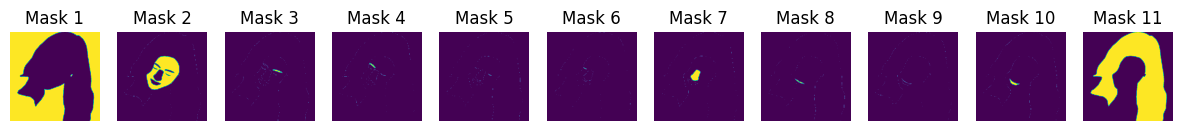

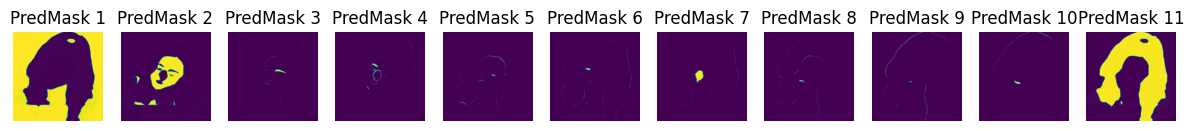

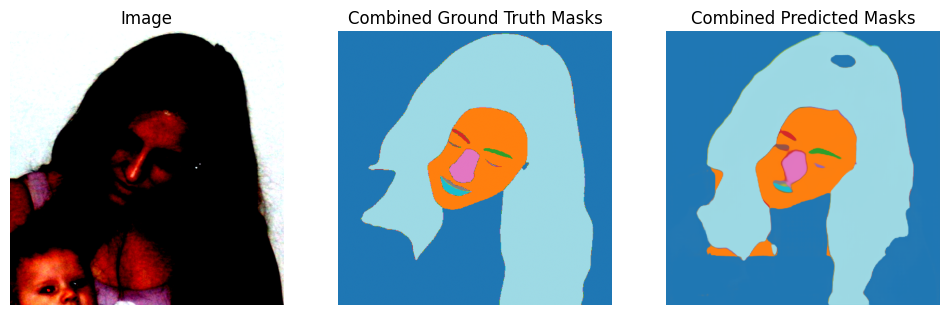

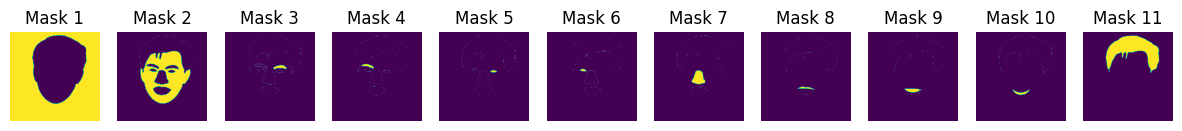

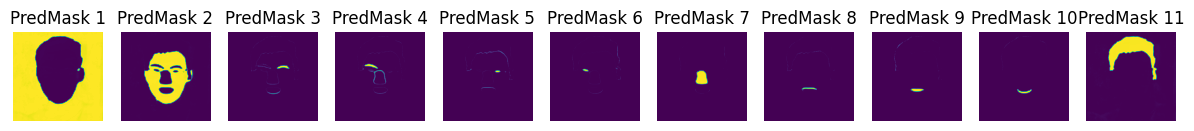

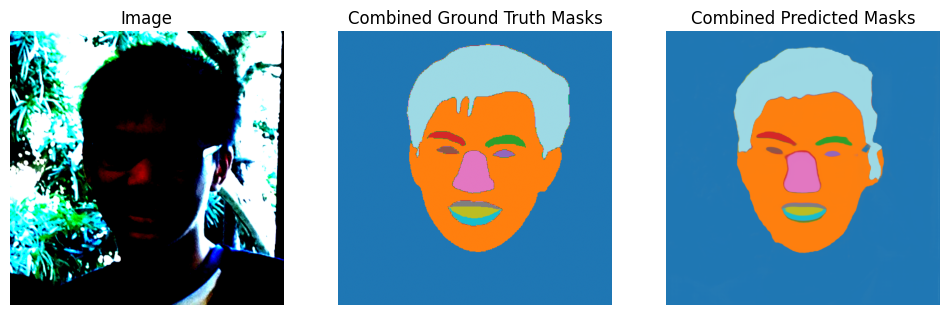

Validation Generator Loss: 10.6576, Validation Dice Coefficient: 0.5450, Validation mIoU: 0.4359
Saving weights-->
[Epoch 1/15] [G loss: 11.698] [D loss: 0.273] ETA: 555.123s


100%|██████████| 105/105 [00:31<00:00,  3.37it/s, loss=14.8]


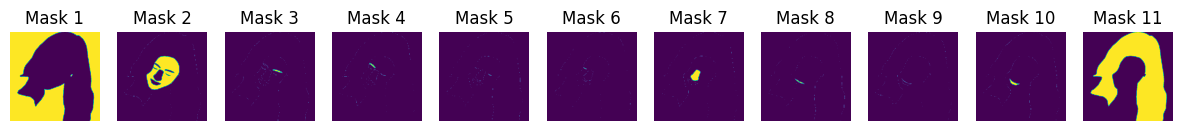

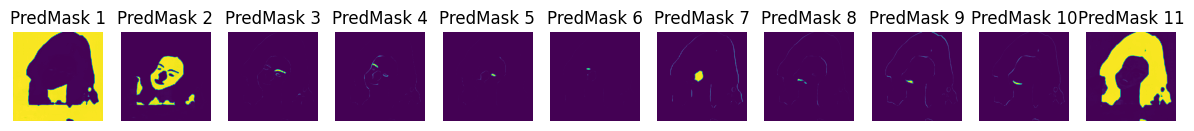

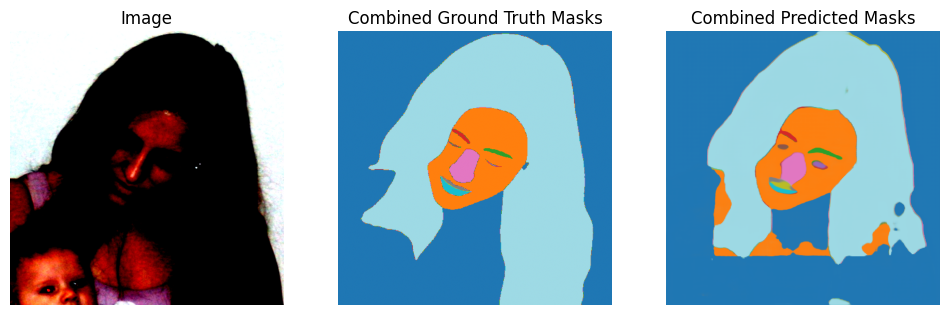

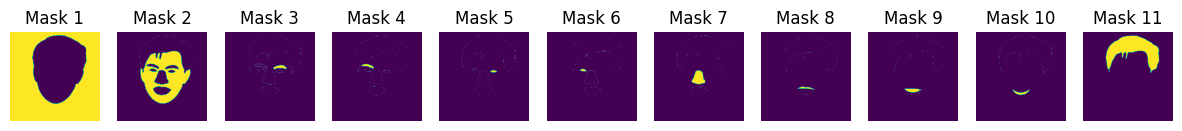

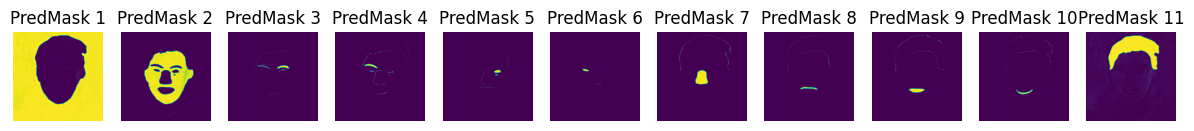

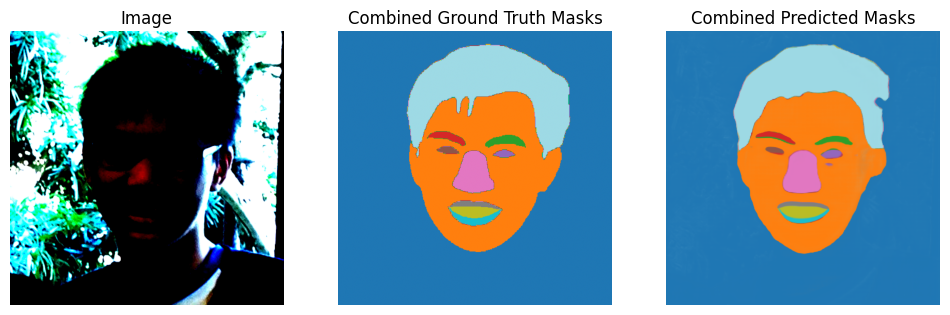

Validation Generator Loss: 17.5204, Validation Dice Coefficient: 0.5713, Validation mIoU: 0.4523
Saving weights-->
[Epoch 2/15] [G loss: 10.612] [D loss: 0.309] ETA: 549.483s


100%|██████████| 105/105 [00:32<00:00,  3.20it/s, loss=10.2]


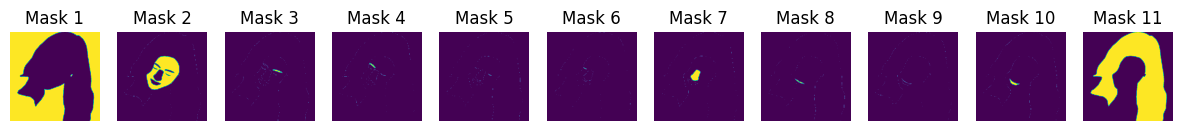

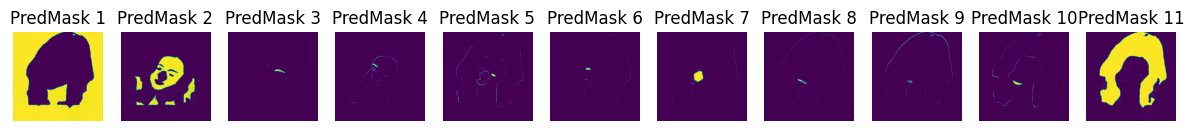

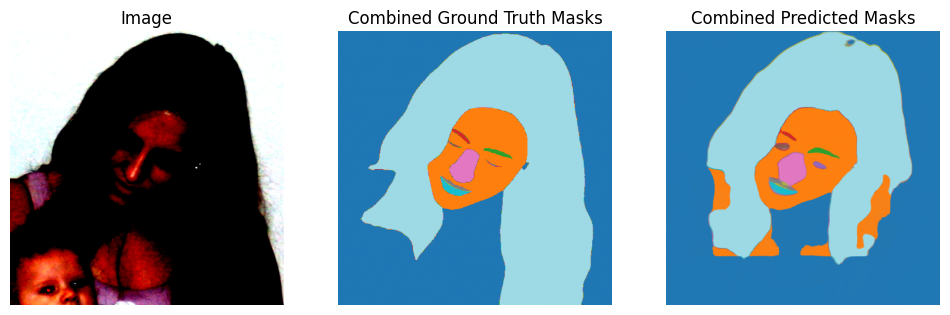

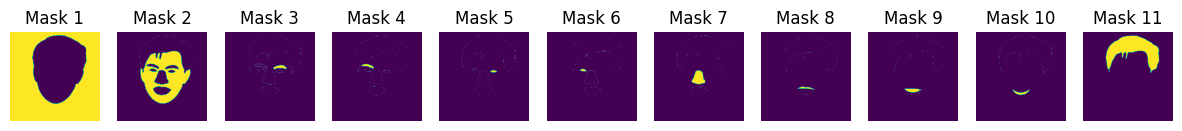

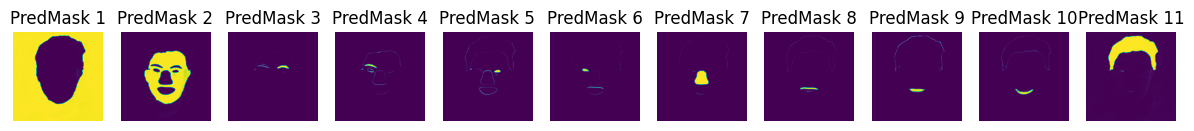

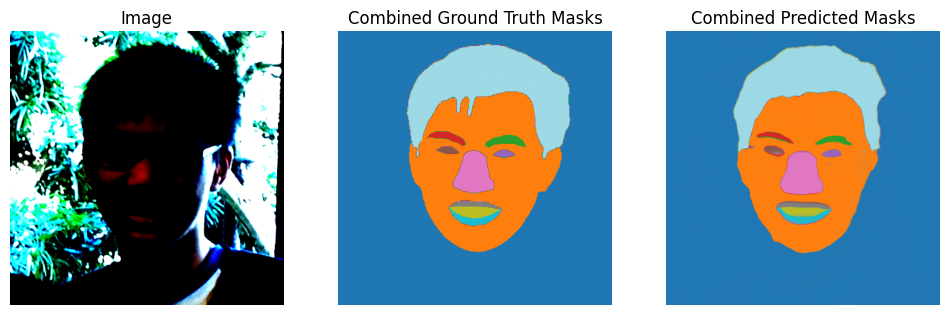

Validation Generator Loss: 12.5415, Validation Dice Coefficient: 0.5673, Validation mIoU: 0.4513
[Epoch 3/15] [G loss: 10.731] [D loss: 0.288] ETA: 558.699s


100%|██████████| 105/105 [00:33<00:00,  3.17it/s, loss=12]


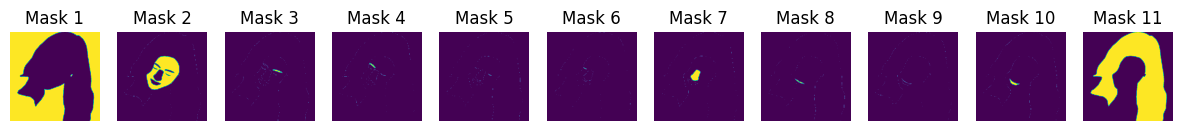

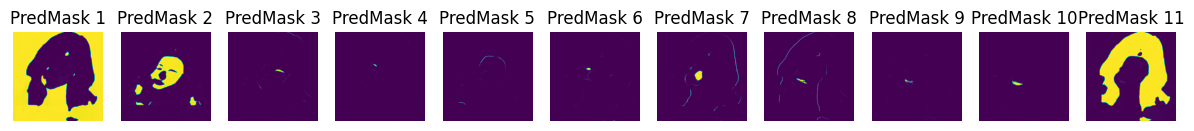

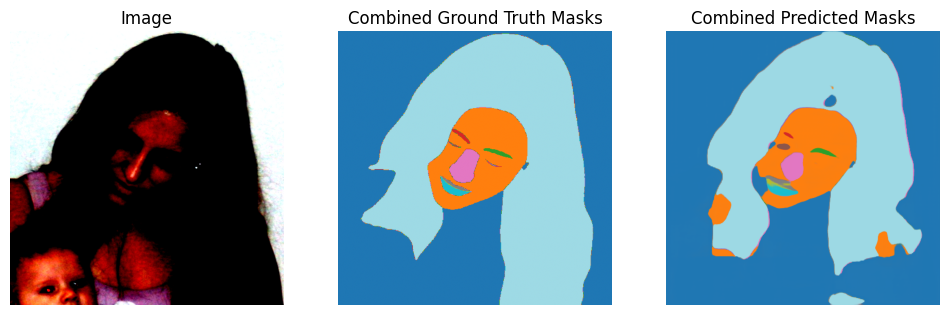

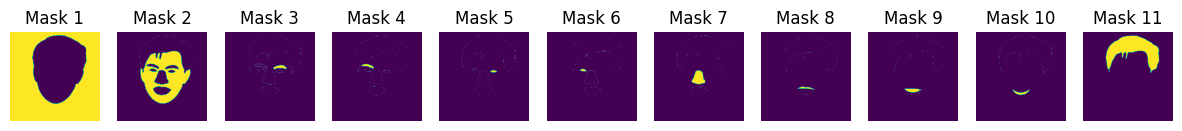

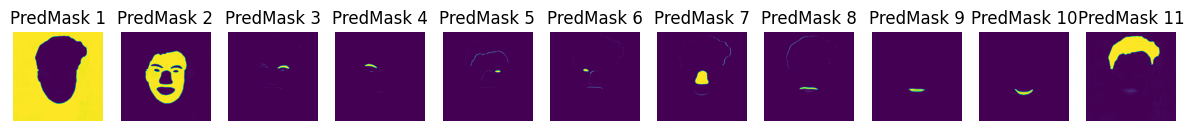

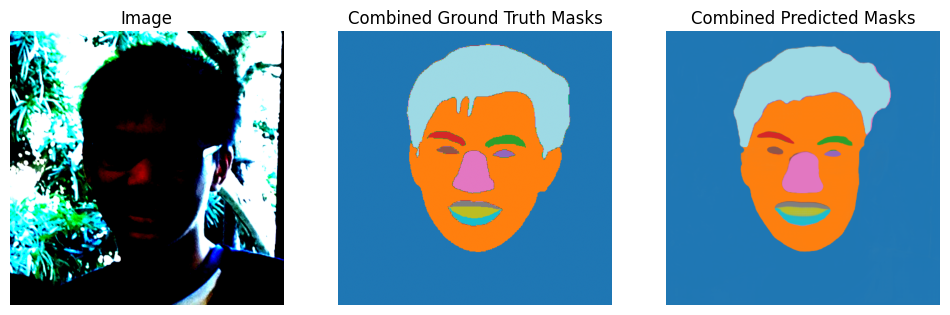

Validation Generator Loss: 13.6241, Validation Dice Coefficient: 0.5670, Validation mIoU: 0.4564
[Epoch 4/15] [G loss: 10.685] [D loss: 0.250] ETA: 566.289s


100%|██████████| 105/105 [00:33<00:00,  3.15it/s, loss=7.64]


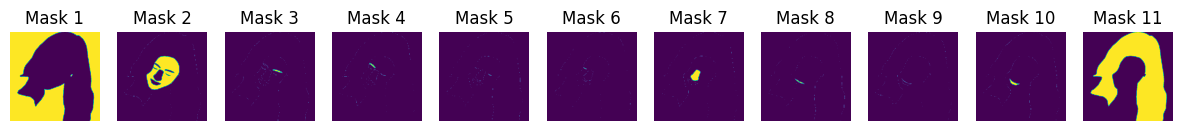

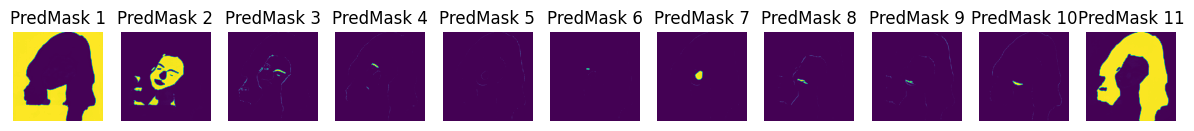

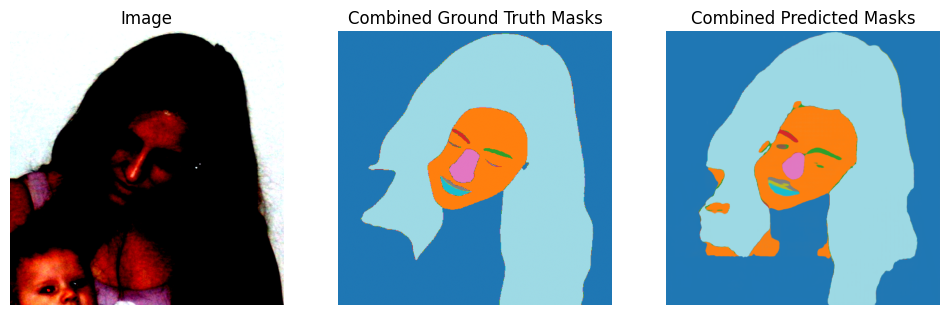

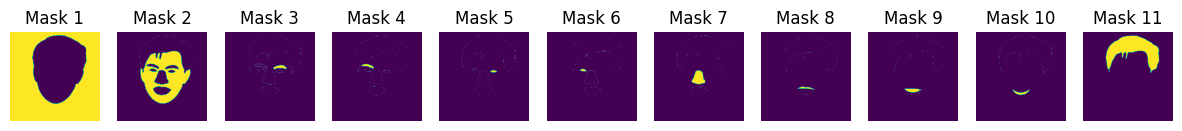

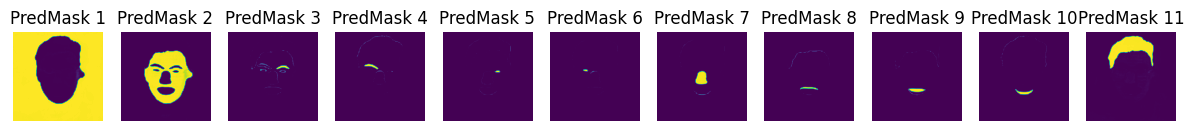

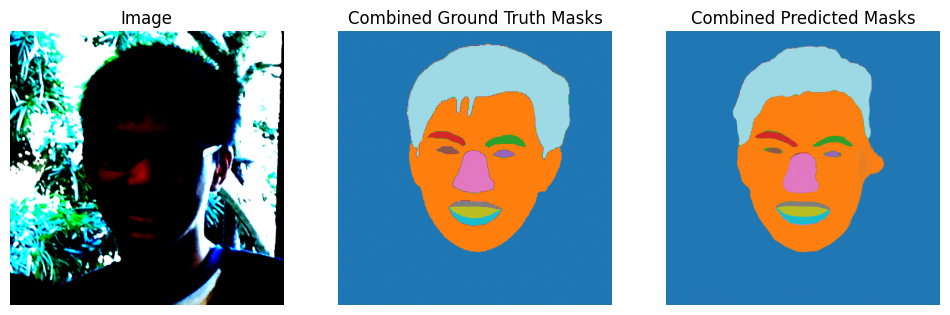

Validation Generator Loss: 13.8966, Validation Dice Coefficient: 0.5692, Validation mIoU: 0.4544
Early stopping at epoch 5


In [ ]:
import pandas as pd
# Set CUDA_LAUNCH_BLOCKING to 1
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# # Ensure the change takes effect
# print(f"CUDA_LAUNCH_BLOCKING is set to {os.environ['CUDA_LAUNCH_BLOCKING']}")
# # Check PyTorch and CUDA versions
# print(f"PyTorch version: {torch.__version__}")
# print(f"CUDA available: {torch.cuda.is_available()}")
# print(f"CUDA version: {torch.version.cuda}")

# Train the model and get the losses and ious/dices
g_losses, d_losses, combined_losses, val_g_losses, train_dice, train_iou, val_dice, val_iou = train_loop(generator, discriminator, train_loader,val_loader, g_criterion, d_criterion, g_optimizer, d_optimizer,device, num_epochs)


In [ ]:
past_epochs = pd.read_csv("/content/GANUNET_df_epochs.csv")
past_epochs

Unnamed: 0  epoch  train_g_loss  train_d_loss  val_g_loss  train_iou  \
0            0      1     27.672757      0.069252   37.724387   0.055792   
1            1      2     21.853661      0.013526   24.773731   0.137845   
2            2      3     18.388354      0.026905   20.362234   0.161471   
3            3      4     15.977097      0.046301   21.782935   0.214107   
4            4      5     14.870156      0.068074   20.687500   0.249018   
5            5      6     15.531695      0.050275   17.016638   0.241298   
6            6      7     16.043985      0.064445   20.452872   0.212384   
7            7      8     14.460912      0.088351   15.967796   0.250870   
8            8      9     12.278815      0.174492   16.554678   0.317529   
9            9     10     13.388544      0.141604   17.006103   0.308678   
10          10     11     12.236604      0.212661   15.100347   0.370100   
11          11     12     11.553403      0.225088   12.939311   0.390987   
12          12     13     11.268452      0.280051   12.071320   0.437605   
13          13     14     10.918522      0.294037   12.185227   0.450787   

    train_dice   val_iou  val_dice  
0     0.076767  0.114187  0.152323  
1     0.173418  0.135897  0.174652  
2     0.198545  0.164278  0.207575  
3     0.260954  0.201264  0.247751  
4     0.305186  0.197074  0.244393  
5     0.285952  0.209187  0.258606  
6     0.249839  0.207473  0.255058  
7     0.301789  0.283136  0.358397  
8     0.391587  0.289952  0.360861  
9     0.388358  0.314676  0.394415  
10    0.463490  0.352697  0.445322  
11    0.488842  0.423418  0.533412  
12    0.548708  0.442826  0.553139  
13    0.562762  0.458149  0.567356

In [ ]:
past_g_losses = past_epochs["train_g_loss"].tolist()
past_val_g_losses = past_epochs["val_g_loss"].tolist()
past_train_iou = past_epochs["train_iou"].tolist()
past_train_dice = past_epochs["train_dice"].tolist()
past_val_iou = past_epochs["val_iou"].tolist()
past_val_dice = past_epochs["val_dice"].tolist()

In [ ]:
# g_losses, d_losses, combined_losses, val_g_losses, train_dice, train_iou
print("train_generator_losses", g_losses)
print("train_discriminator_losses", d_losses)
print("train_combined_losses", combined_losses)
print("val_generator_losses", val_g_losses)
print("train_iou", train_iou)
print("train_dice", train_dice)
print("val_iou", val_iou)
print("val_dice", val_dice)

train_generator_losses [11.697581528027852, 10.612230105400085, 10.730626200437547, 10.685039276679356, 10.717024276256561]
train_discriminator_losses [0.27318150610662995, 0.3089316498860717, 0.28786955821638305, 0.24976404427550733, 0.2736231056507677]
train_combined_losses [11.970763034134482, 10.921161755286157, 11.01849575865393, 10.934803320954863, 10.990647381907328]
val_generator_losses [10.65759890193031, 17.52037747701009, 12.54150431950887, 13.62408044451759, 13.896624851226807]
train_iou [0.451993147234122, 0.4582573628425598, 0.4655563019712766, 0.4696072367330392, 0.47298903375864026]
train_dice [0.5661889834702015, 0.5722218896945318, 0.5789495841165384, 0.5830517153441906, 0.5878564030428728]
val_iou [0.4359331345274335, 0.4523095871720995, 0.4513096779584885, 0.4563714027404785, 0.45437006638163613]
val_dice [0.5450239104884012, 0.571319854259491, 0.5673118315991901, 0.5669984482583545, 0.5691651594071161]


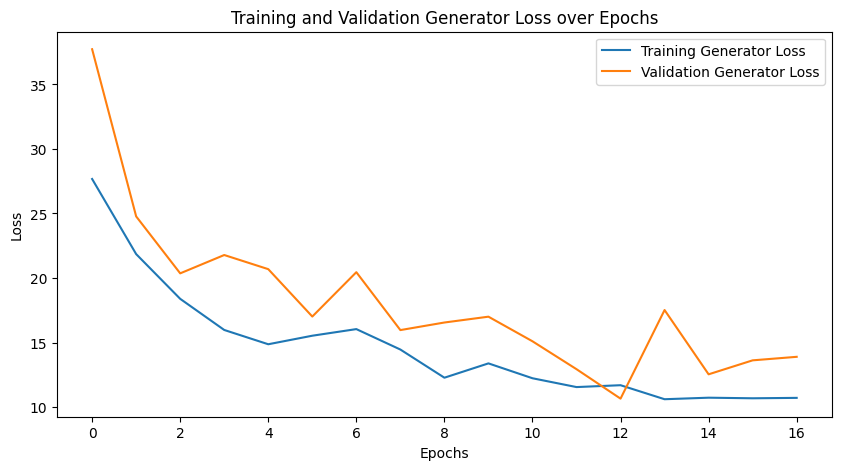

In [ ]:
# Plot the losses

plt.figure(figsize=(10, 5))
plt.plot(past_g_losses[:12]+g_losses, label='Training Generator Loss')
plt.plot(past_val_g_losses[:12]+val_g_losses, label='Validation Generator Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Generator Loss over Epochs')
plt.legend()
plt.show()

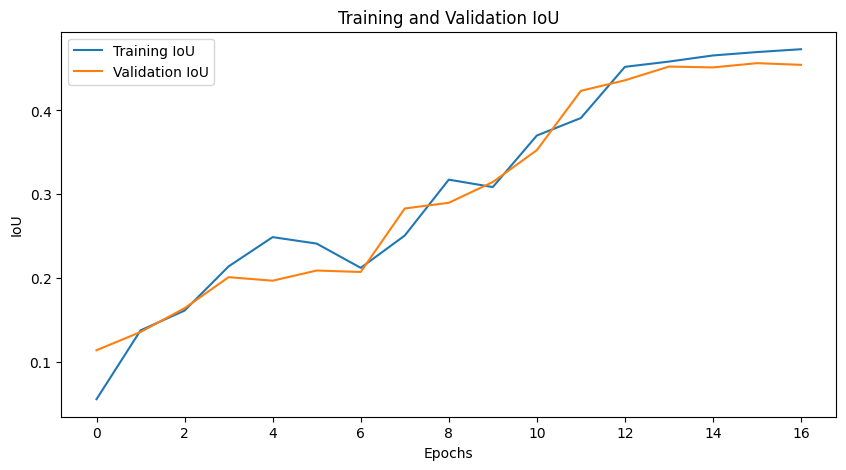

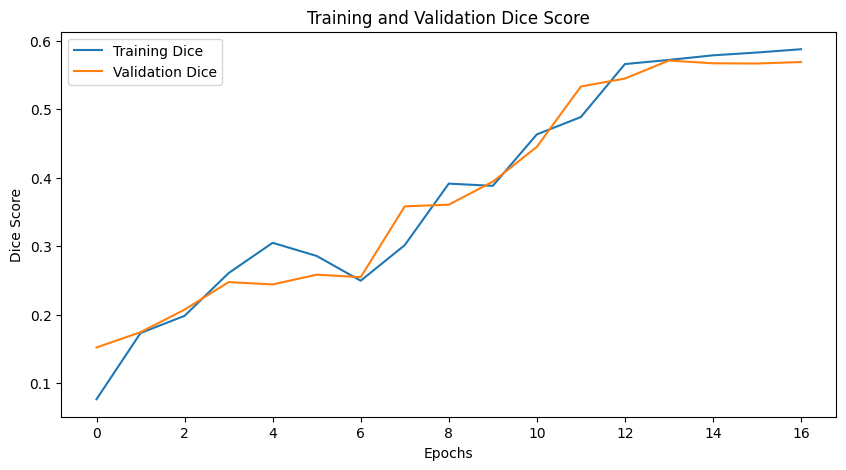

In [ ]:
# Plot ious and dices

plt.figure(figsize=(10, 5))
plt.plot(past_train_iou[:12]+train_iou, label='Training IoU')
plt.plot(past_val_iou[:12]+val_iou, label='Validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.title('Training and Validation IoU')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(past_train_dice[:12]+train_dice, label='Training Dice')
plt.plot(past_val_dice[:12]+val_dice, label='Validation Dice')
plt.xlabel('Epochs')
plt.ylabel('Dice Score')
plt.title('Training and Validation Dice Score')
plt.legend()
plt.show()


In [ ]:
from google.colab import files

file_path = '/content/UNET.weights.pth.tar_15'
# Download the file
files.download(file_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [34]:
load_checkpoint("/content/drive/MyDrive/15GANUNET.weights.pth.tar_1", generator, discriminator, g_optimizer, d_optimizer, device)

Loading weights-->


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1898: UserWarning: Positional args are being deprecated, use kwargs instead. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


TypeError: Optimizer.state_dict() takes 1 positional argument but 2 were given

In [ ]:
avg_iou, avg_dice, cm = test_loop(generator, test_loader, nn.BCELoss(), device, 11)

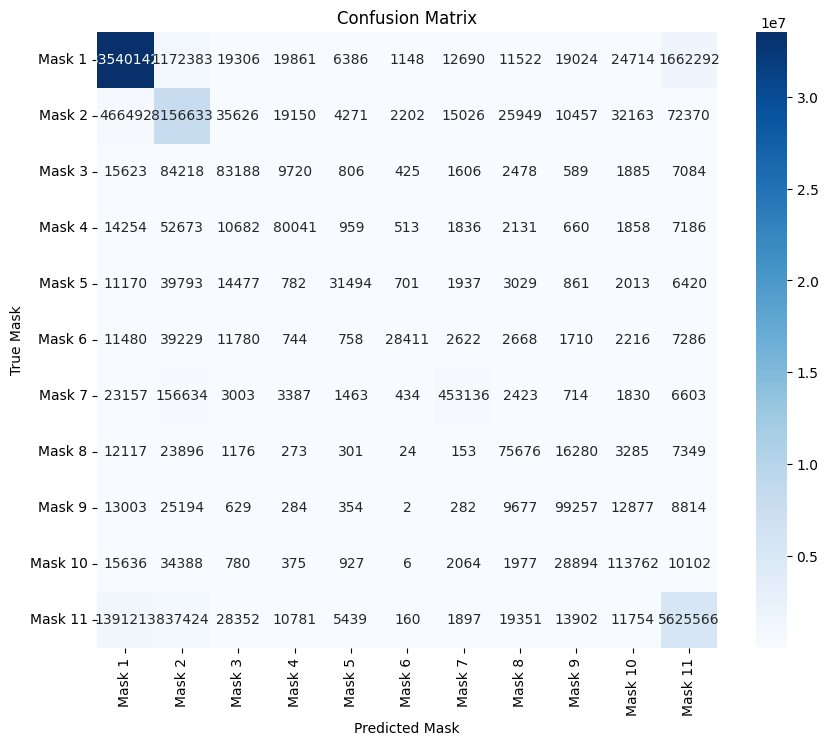

In [ ]:
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[f'Mask {i+1}' for i in range(num_masks)], yticklabels=[f'Mask {i+1}' for i in range(num_masks)])
plt.xlabel('Predicted Mask')
plt.ylabel('True Mask')
plt.title('Confusion Matrix')
plt.show()

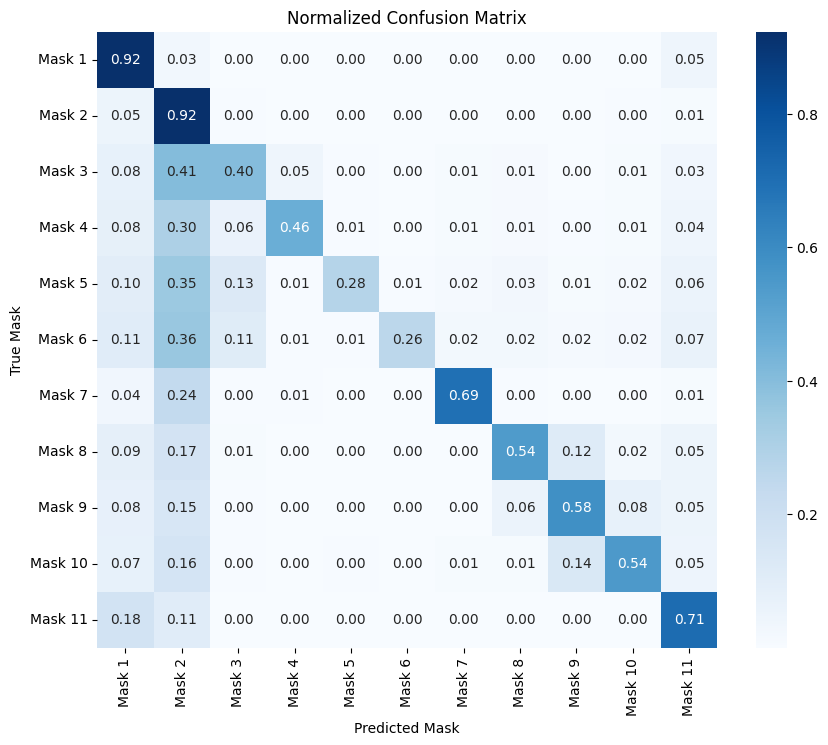

In [ ]:
# Normalize the confusion matrix by row (true labels)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the normalized confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=[f'Mask {i+1}' for i in range(num_masks)],
            yticklabels=[f'Mask {i+1}' for i in range(num_masks)])
plt.xlabel('Predicted Mask')
plt.ylabel('True Mask')
plt.title('Normalized Confusion Matrix')
plt.show()

In [ ]:
def print_masks0(image,mask,pred,num_masks):
  with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        num_masks = 11
        fig, axes = plt.subplots(1, num_masks, figsize=(15, 15))
        fig1, axes1 = plt.subplots(1, num_masks, figsize=(15, 15))
        fig2, axes2 = plt.subplots(1,3,figsize=(12,4))

        # Display each mask
        for m in range(num_masks):
            axes[m].imshow(mask[0][m].cpu())
            axes[m].set_title(f'Mask {m + 1}')
            axes[m].axis('off')

        for m in range(num_masks):
            axes1[m].imshow(pred[0][m].detach().cpu().numpy())
            axes1[m].set_title(f'PredMask {m + 1}')
            axes1[m].axis('off')
        # for m in range(num_masks):
        #     binary_pred = (pred[0][m] > 0.0).float()
        #     axes2[m].imshow(binary_pred.detach().cpu().numpy(), cmap='viridis')
        #     axes2[m].set_title(f'Pred Mask {m + 1}')
        #     axes2[m].axis('off')

        colors = plt.cm.get_cmap('tab20', num_masks)  # Use a colormap with 20 colors
        # Create combined masks with different colors
        combined_mask = np.zeros((512, 512, 3))
        combined_pred = np.zeros((512, 512, 3))
        combined_binary_pred = np.zeros((512, 512, 3))

        for m in range(num_masks):
            color = colors(m)[:3]  # Get RGB values from colormap
            combined_mask += np.stack([mask[0, m].cpu().numpy()] * 3, axis=-1) * color
            combined_pred += np.stack([pred[0, m].detach().cpu().numpy()] * 3, axis=-1) * color
            # binary_pred = (pred[0, m] > 0.0).float()
            # combined_binary_pred += np.stack([binary_pred.detach().cpu().numpy()] * 3, axis=-1) * color


        axes2[0].imshow(np.array(image[0].permute(1,2,0).cpu()))
        axes2[0].set_title('Image')
        axes2[0].axis('off')

        axes2[1].imshow(combined_mask)
        axes2[1].set_title('Combined Ground Truth Masks')
        axes2[1].axis('off')

        axes2[2].imshow(combined_pred)
        axes2[2].set_title('Combined Predicted Masks')
        axes2[2].axis('off')
plt.show()
plt.close(fig)

In [ ]:
def print_masks1(image,mask,pred,num_masks):
    num_masks = 11
    fig, axes = plt.subplots(1, num_masks, figsize=(15, 15))
    fig1, axes1 = plt.subplots(1, num_masks, figsize=(15, 15))
    fig2, axes2 = plt.subplots(1,3,figsize=(12,4))

    # Display each mask
    for m in range(num_masks):
        axes[m].imshow(mask[1][m].cpu())
        axes[m].set_title(f'Mask {m + 1}')
        axes[m].axis('off')

    for m in range(num_masks):
        axes1[m].imshow(pred[1][m].detach().cpu().numpy())
        axes1[m].set_title(f'PredMask {m + 1}')
        axes1[m].axis('off')
    # for m in range(num_masks):
    #     binary_pred = (pred[0][m] > 0.0).float()
    #     axes2[m].imshow(binary_pred.detach().cpu().numpy(), cmap='viridis')
    #     axes2[m].set_title(f'Pred Mask {m + 1}')
    #     axes2[m].axis('off')

    colors = plt.cm.get_cmap('tab20', num_masks)  # Use a colormap with 20 colors
    # Create combined masks with different colors
    combined_mask = np.zeros((512, 512, 3))
    combined_pred = np.zeros((512, 512, 3))
    combined_binary_pred = np.zeros((512, 512, 3))

    for m in range(num_masks):
        color = colors(m)[:3]  # Get RGB values from colormap
        combined_mask += np.stack([mask[1, m].cpu().numpy()] * 3, axis=-1) * color
        combined_pred += np.stack([pred[1, m].detach().cpu().numpy()] * 3, axis=-1) * color
        # binary_pred = (pred[0, m] > 0.0).float()
        # combined_binary_pred += np.stack([binary_pred.detach().cpu().numpy()] * 3, axis=-1) * color


    axes2[0].imshow(np.array(image[1].permute(1,2,0).cpu()))
    axes2[0].set_title('Image')
    axes2[0].axis('off')

    axes2[1].imshow(combined_mask)
    axes2[1].set_title('Combined Ground Truth Masks')
    axes2[1].axis('off')

    axes2[2].imshow(combined_pred)
    axes2[2].set_title('Combined Predicted Masks')
    axes2[2].axis('off')
plt.show()
plt.close(fig)

In [ ]:
it = iter(test_loader)
image, mask = next(it)
image, mask = image.to(device), mask.to(device)
generator.eval()
pred = generator(image)

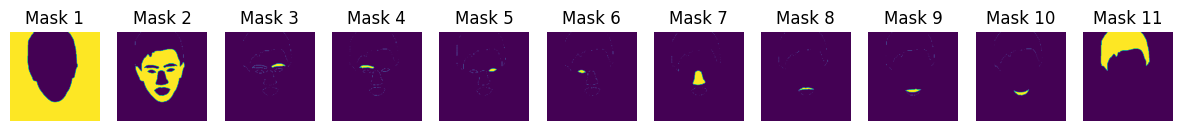

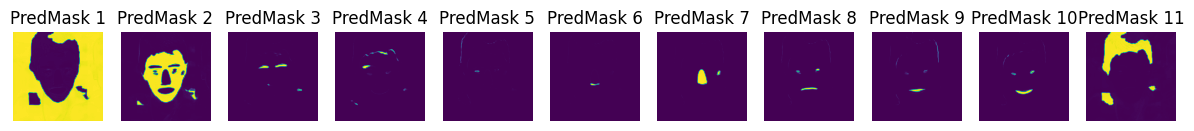

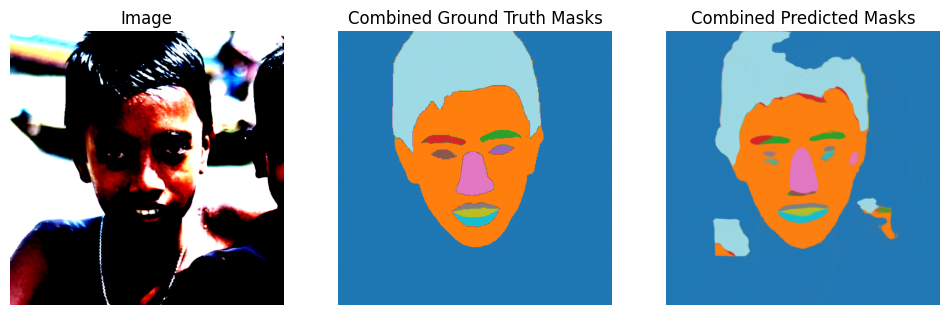

In [ ]:
print_masks0(image,mask,pred,11)

<ipython-input-35-b69fc493c72f>:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', num_masks)  # Use a colormap with 20 colors


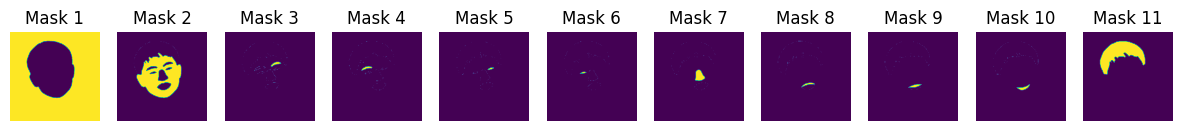

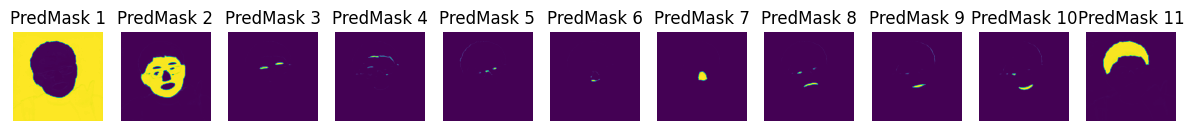

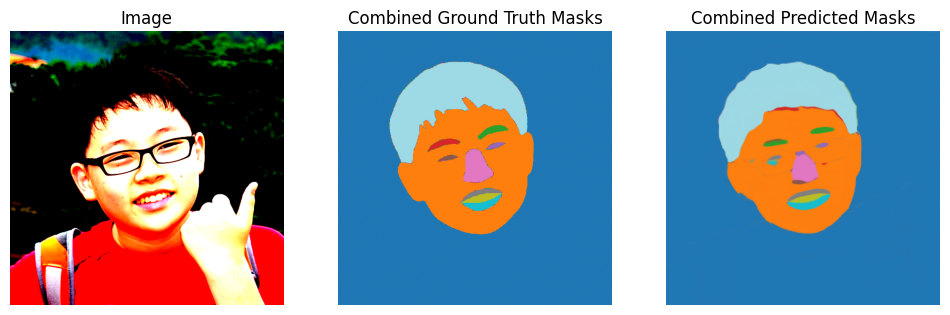

In [ ]:
print_masks1(image,mask,pred,11)

In [ ]:
image, mask = next(it)
image, mask = image.to(device), mask.to(device)
generator.eval()
pred = generator(image)

NameError: name 'model' is not defined

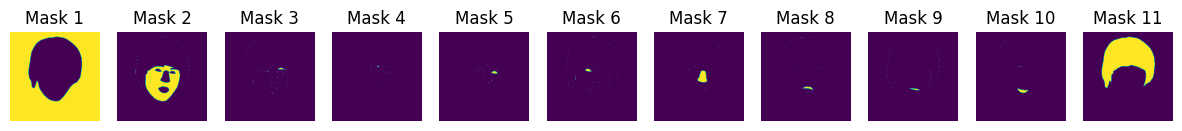

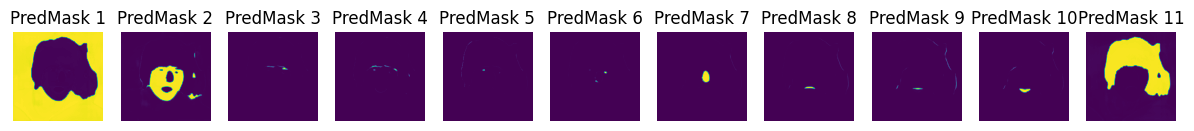

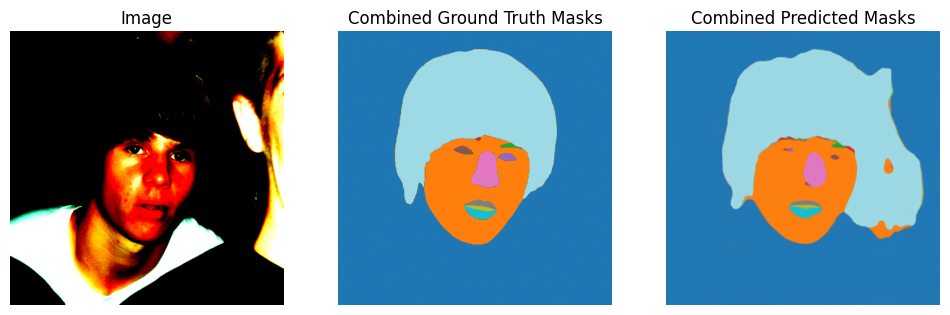

In [ ]:
print_masks0(image,mask,pred,11)

<ipython-input-35-b69fc493c72f>:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', num_masks)  # Use a colormap with 20 colors


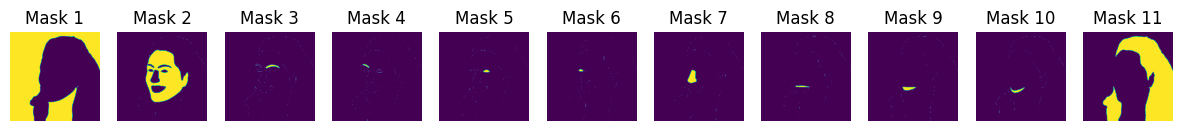

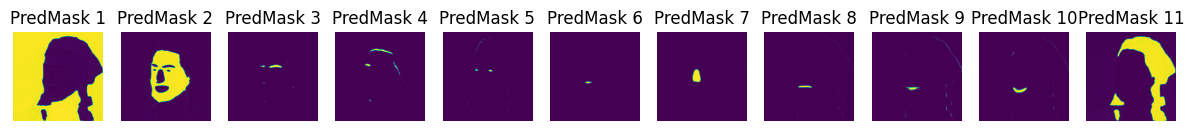

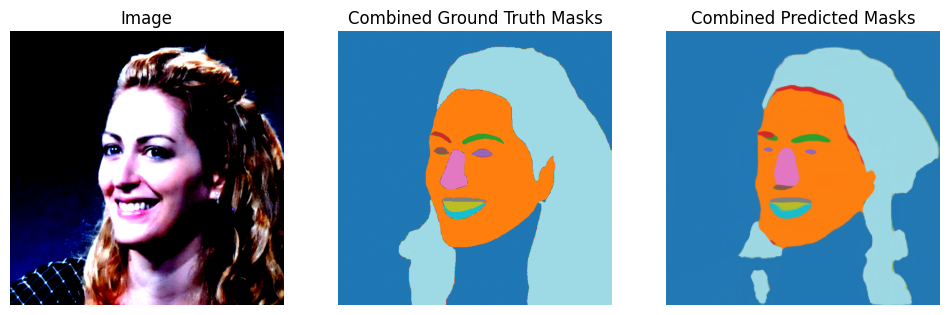

In [ ]:
print_masks1(image,mask,pred,11)

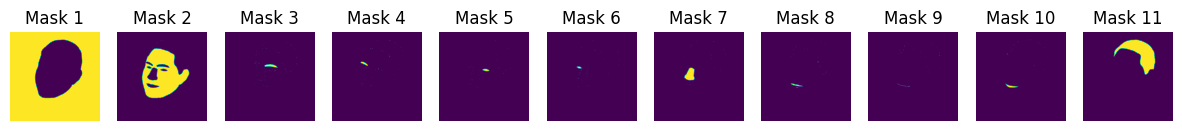

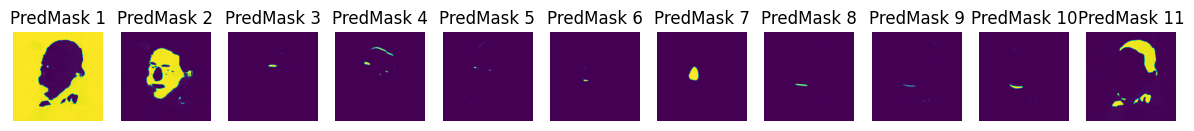

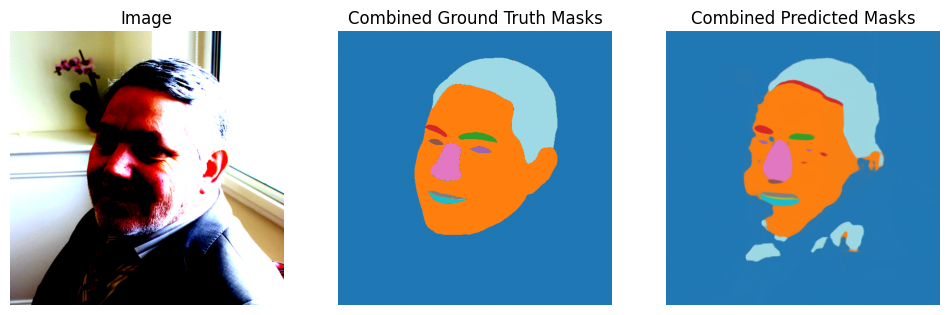

In [ ]:
image, mask = next(it)
image, mask = image.to(device), mask.to(device)
generator.eval()
pred = generator(image)

print_masks0(image,mask,pred,11)

<ipython-input-35-b69fc493c72f>:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', num_masks)  # Use a colormap with 20 colors


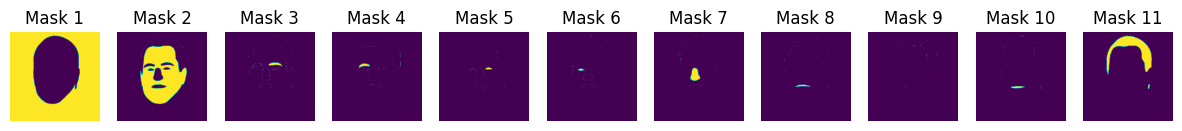

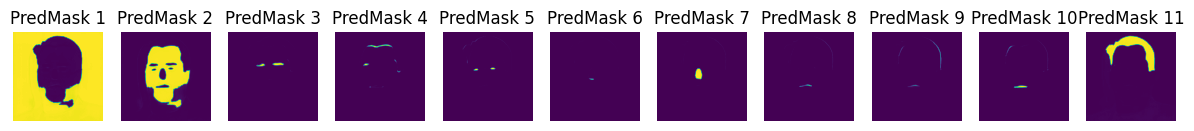

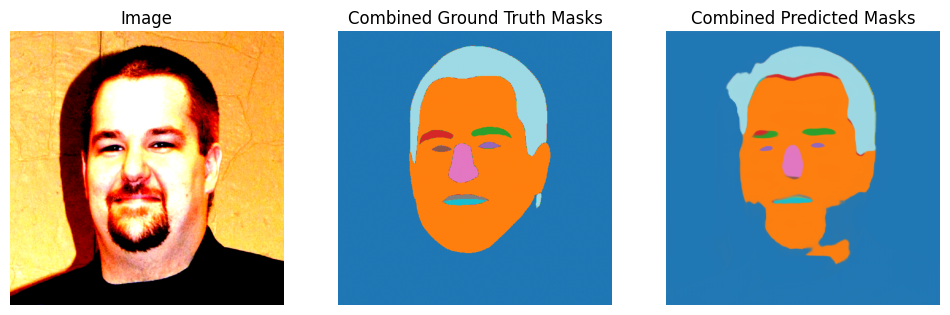

In [ ]:
print_masks1(image,mask,pred,11)

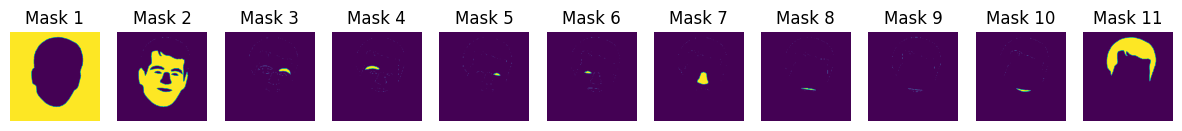

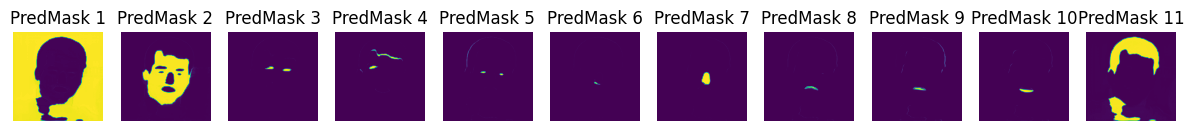

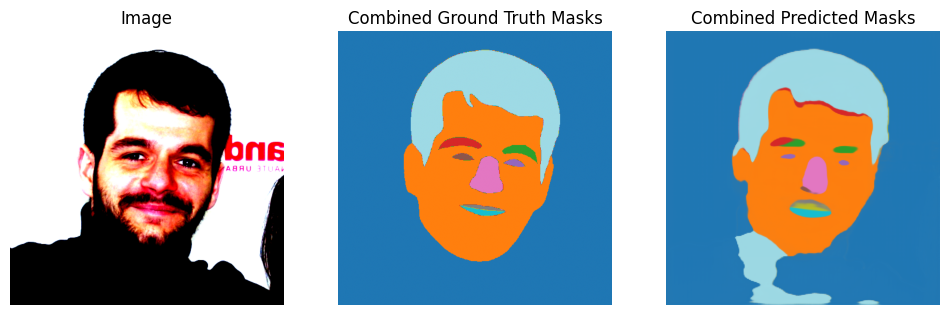

In [ ]:
image, mask = next(it)
image, mask = image.to(device), mask.to(device)
generator.eval()
pred = generator(image)

print_masks0(image,mask,pred,11)

<ipython-input-35-b69fc493c72f>:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', num_masks)  # Use a colormap with 20 colors


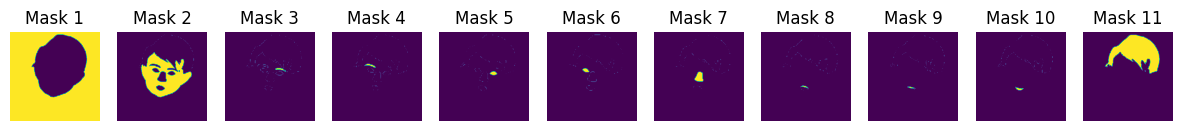

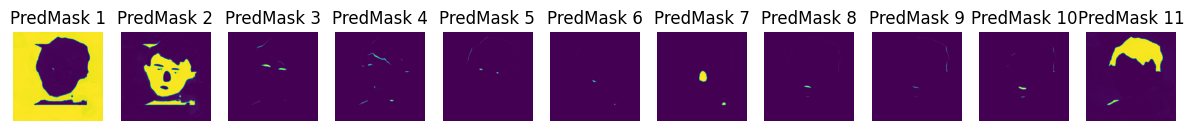

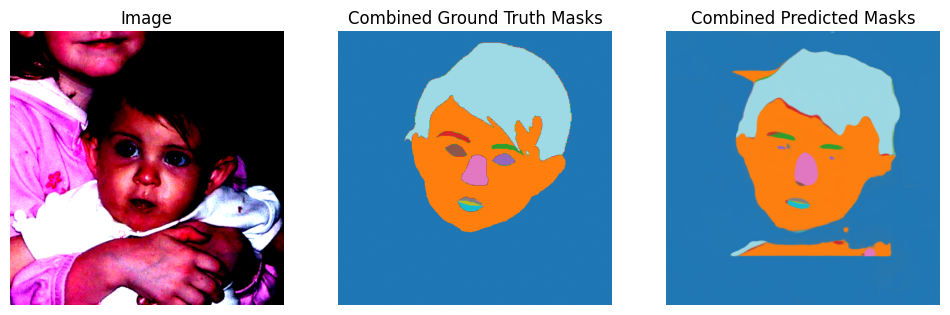

In [ ]:
print_masks1(image,mask,pred,11)

In [34]:
import torch
import torch.nn as nn

class ResUNet(nn.Module):
    def __init__(self, in_channels=3, num_classes=11, f = [64, 128, 256, 512]):
        super(ResUNet, self).__init__()

        # Encoding
        self.input_block_layer = self.input_block(in_channels, 64)
        self.input_skip_layer = self.input_skip(in_channels, 64)

        self.db_conv1 = self.double_conv(64, 128)
        self.skip1 = self.skip(64, 128)

        self.db_conv2 = self.double_conv(128, 256)
        self.skip2 = self.skip(128, 256)

        # self.db_conv3 = self.double_conv(256, 512)
        # self.skip3 = self.skip(256, 512)

        # Bridge
        self.bridge_layer = self.double_conv(256, 512)
        # self.bridge_layer = self.bridge(256)

        # Decoding
        self.up_1_layer = self.upsample(512)
        self.db_conv4 = self.double_conv(512 + 256, 256, stride = 1)
        self.skip4 = self.skip(512 + 256, 256, stride = 1)

        self.up_2_layer = self.upsample(256)
        self.db_conv5 = self.double_conv(256 + 128, 128, stride = 1)
        self.skip5 = self.skip(256 + 128, 128, stride = 1)

        self.up_3_layer = self.upsample(128)
        self.db_conv6 = self.double_conv(128 + 64, 64, stride = 1)
        self.skip6 = self.skip(128 + 64, 64, stride = 1)

        self.final_conv = nn.Sequential(
            nn.Conv2d(64, num_classes, 1, 1),
            # nn.Sigmoid(),
        )

    def bridge(self, channels, kernel_size=3, stride=1):
        bridge = nn.Sequential(
            nn.BatchNorm2d(channels),
            nn.ReLU(),
            nn.Conv2d(channels, channels, kernel_size=kernel_size, stride=2, padding=1), # try stride 2
            nn.BatchNorm2d(channels),
            nn.ReLU(),
            nn.Conv2d(channels, channels, kernel_size=kernel_size, padding=1),
        )
        return bridge

    def input_block(self, in_channels, out_channels):
        input_block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same', stride=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding='same', stride=1),
        )
        return input_block

    def input_skip(self, in_channels, out_channels):
        input_skip = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, padding='same')
        )
        return input_skip

    def double_conv(self, in_channels, out_channels, kernel_size=3, stride=2):
        conv_block = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(),
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride = stride, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride = 1, padding=1),
        )
        return conv_block

    def skip(self, in_channels, out_channels, kernel_size=3, stride=2):
        conv_skip = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
        )
        return conv_skip

    def upsample(self, channels): # non cambia il numero di canali
        return nn.ConvTranspose2d(channels, channels, kernel_size=2, stride=2)

    def forward(self, x):
        # Encode
        x1 = self.input_block_layer(x) + self.input_skip_layer(x)
        # print('x1', x1.shape)
        x2 = self.db_conv1(x1) + self.skip1(x1)
        # print('x2', x2.shape)
        x3 = self.db_conv2(x2) + self.skip2(x2)
        # print('x3', x3.shape)
        # x4 = self.db_conv3(x3) + self.skip3(x3)
        # print('x4', x4.shape)


        # Bridge
        x4 = self.bridge_layer(x3)
        # print('x4', x4.shape)

        # Decode
        x5 = self.up_1_layer(x4)
        # print('x5', x5.shape)
        x6 = torch.cat([x3, x5], dim=1)
        # print('x6', x6.shape)
        x7 = self.db_conv4(x6) + self.skip4(x6)
        # print('x7', x7.shape)

        x8 = self.up_2_layer(x7)
        # print('x8', x8.shape)
        x9 = torch.cat([x8, x2], dim=1)
        # print('x9', x9.shape)
        x10 = self.db_conv5(x9) + self.skip5(x9)
        # print('x10', x10.shape)

        x11 = self.up_3_layer(x10)
        # print('x11', x11.shape)
        x12 = torch.cat([x1, x11], dim=1)
        # print('x12', x12.shape)
        x13 = self.db_conv6(x12) + self.skip6(x12)
        # print('x13', x13.shape)


        output = self.final_conv(x13)

        return output

In [14]:
# Depth Residual Seperable UNet
# Different from VanillaUNet - has skip connections inside Conv blocks, uses Depth Seperable Conv ops
# resulting in lesser computations

class DRSUNet(nn.Module):
    def __init__(self,in_channels=3,num_classes=11):
        super(DRSUNet, self).__init__()
        # Encode architecture
        self.dsconv1_1 = self._depth_seperable_conv(in_channels, 64)
        self.dsconv1_2 = self._depth_seperable_conv(64, 64)
        self.dsconv2_1 = self._depth_seperable_conv(64, 64)
        self.dsconv2_2 = self._depth_seperable_conv(128, 128)
        self.dsconv3_1 = self._depth_seperable_conv(128, 128)
        self.dsconv3_2 = self._depth_seperable_conv(256, 256)
        self.dsconv4_1 = self._depth_seperable_conv(256, 256)
        self.dsconv4_2 = self._depth_seperable_conv(512, 512)
        self.dsconv5_1 = self._depth_seperable_conv(512, 512)
        self.dsconv5_2 = self._depth_seperable_conv(1024, 1024)
        # Decoder architecture
        self.uconv1 = nn.ConvTranspose2d(1024,512,stride=2,kernel_size=2)
        self.dconv6 = self._double_conv(1024, 512)
        self.uconv2 = nn.ConvTranspose2d(512, 256,stride=2,kernel_size=2)
        self.dconv7 = self._double_conv(512, 256)
        self.uconv3 = nn.ConvTranspose2d(256, 128,stride=2,kernel_size=2)
        self.dconv8 = self._double_conv(256, 128)
        self.uconv4 = nn.ConvTranspose2d(128, 64,stride=2,kernel_size=2)
        self.dconv9 = self._double_conv(128, 64)
        # Final conv
        self.final_conv = nn.Conv2d(64,num_classes,kernel_size=1)
        # Max pool
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def _depth_seperable_conv(self, in_channels, out_channels):
        # Modifying Conv2d such that it performs 2 operations
        # 1. Depth wise convolution
        # 2. Point wise convolution
        # The 2 consecutive Conv2d represent the Depth Wise & Point Wise Conv operations respectively
        depth_seperable_conv = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, groups=in_channels, kernel_size=3, padding='same'),
            nn.Conv2d(in_channels, out_channels, kernel_size=1, padding='same'),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True)
        )
        return depth_seperable_conv

    def _double_conv(self, in_channels,out_channels):
        conv = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, groups=in_channels, kernel_size=3, padding='same'),
            nn.Conv2d(in_channels, out_channels, kernel_size=1, padding='same'),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, groups=out_channels, kernel_size=3, padding='same'),
            nn.Conv2d(out_channels, out_channels, kernel_size=1, padding='same'),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True)
        )
        return conv

    def forward(self,X0):
        # Forward Prop thru Encoder
        # X Shape : [B X 3 X 512 X 512]
        X1 = self.dsconv1_1(X0)          # X1 Shape : [B X 64 X 512 X 512]
        X2 = self.dsconv1_2(X1)          # X2 Shape : [B X 64 X 512 X 512]

        X3 = self.max_pool(X2)           # X3 Shape : [B X 64 X 256 X 256]

        X4 = self.dsconv2_1(X3)          # X4 Shape : [B X 64 X 256 X 256]
        X5 = torch.cat((X3,X4),dim=1)    # X5 Shape : [B X 128 X 256 X 256]
        X6 = self.dsconv2_2(X5)          # X6 Shape : [B X 128 X 256 X 256]

        X7 = self.max_pool(X6)           # X7 Shape : [B X 128 X 128 X 128]

        X8 = self.dsconv3_1(X7)          # X8 Shape : [B X 128 X 128 X 128]
        X9 = torch.cat((X7,X8),dim=1)    # X9 Shape : [B X 256 X 128 X 128]
        X10 = self.dsconv3_2(X9)         # X10 Shape : [B X 256 X 128 X 128]

        X11 = self.max_pool(X10)         # X11 Shape : [B X 256 X 64 X 64]

        X12 = self.dsconv4_1(X11)        # X12 Shape : [B X 256 X 64 X 64]
        X13 = torch.cat((X11,X12),dim=1) # X13 Shape : [B X 512 X 64 X 64]
        X14 = self.dsconv4_2(X13)        # X14 Shape : [B X 512 X 64 X 64]

        X15 = self.max_pool(X14)         # X15 Shape : [B X 512 X 32 X 32]

        X16 = self.dsconv5_1(X15)        # X16 Shape : [B X 512 X 32 X 32]
        X17 = torch.cat((X15,X16),dim=1) # X17 Shape : [B X 1024 X 32 X 32]
        X18 = self.dsconv5_2(X17)        # X18 Shape : [B X 1024 X 32 X 32]

        # Forward Prop thru Decoder
        X19 = self.uconv1(X18)           # X19 Shape : [B X 512 X 64 X 64]
        X20 = torch.cat((X19,X14),dim=1) # X20 Shape : [B X 1024 X 64 X 64]
        X21 = self.dconv6(X20)           # X21 Shape : [B X 512 X 64 X 64]

        X22 = self.uconv2(X21)           # X22 Shape : [B X 256 X 128 X 128]
        X23 = torch.cat((X22,X10),dim=1) # X23 Shape : [B X 512 X 128 X 128]
        X24 = self.dconv7(X23)           # X24 Shape : [B X 256 X 128 X 128]

        X25 = self.uconv3(X24)            # X25 Shape : [B X 128 X 256 X 256]
        X26 = torch.cat((X25,X6),dim=1)   # X26 Shape : [B X 256 X 256 X 256]
        X27 = self.dconv8(X26)            # X27 Shape : [B X 128 X 256 X 256]

        X28 = self.uconv4(X27)            # X28 Shape : [B X 64 X 512 X 512]
        X29 = torch.cat((X28,X2),dim=1)   # X29 Shape : [B X 128 X 512 X 512]
        X30 = self.dconv9(X29)            # X30 Shape : [B X 64 X 512 X 512]

        # Final Conv Layer
        X31 = self.final_conv(X30)        # X31 Shape : [B X num_classes X 512 X 512]

        return X31 #F.softmax(X31,dim=1)

# RESTO

In [15]:
# Save checkpoint
def save_checkpoint(state,epoch,filename='DRSU.weights.pth.tar_'):
    print('Saving weights-->')
    torch.save(state,filename+str(epoch))


# Load checkpoint
def load_checkpoint(filename,model,optim,device):
    print('Loading weights-->')
    checkpoint = torch.load(filename, map_location=device)
    #checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['state_dict'])
    optim.load_state_dict(checkpoint['optimizer'])

    # Move the model and optimizer to the correct device
    model.to(device)
    for state in optimizer.state.values():
        if isinstance(state, torch.Tensor):
            state.data = state.data.to(device)
            if state._grad is not None:
                state._grad.data = state._grad.data.to(device)



In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
learning_rate = 0.0001


In [17]:
model = ResUNet(3,11).to(device)

NameError: name 'ResUNet' is not defined

In [18]:
model = DRSUNet(3, 11).to(device)

In [19]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.98), eps=1e-9)

In [20]:
# Save checkpoint
def save_checkpoint(state,epoch,filename='DRSU.weights.pth.tar_'):
    print('Saving weights-->')
    torch.save(state,filename+str(epoch))


# Load checkpoint
def load_checkpoint(filename,model,optim,device):
    print('Loading weights-->')
    checkpoint = torch.load(filename, map_location=device)
    #checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['state_dict'])
    optim.load_state_dict(checkpoint['optimizer'])

    # Move the model and optimizer to the correct device
    model.to(device)
    for state in optimizer.state.values():
        if isinstance(state, torch.Tensor):
            state.data = state.data.to(device)
            if state._grad is not None:
                state._grad.data = state._grad.data.to(device)

In [21]:
load_checkpoint('/content/drive/MyDrive/DRSU.weights.pth.tar_6',model,optimizer,device)

Loading weights-->


In [22]:
def test_loop(model, dataloader, loss_fun, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    total_iou = 0.0
    total_dice = 0.0
    num_batches = 0
    accuracy = 0.0

    # Initialize confusion matrix
    cm = np.zeros((num_masks, num_masks), dtype=int)

    loop = tqdm(enumerate(dataloader), total=len(dataloader), leave=True)
    with torch.no_grad():
        for batch, (orig_x,x, y) in loop:
            # put on cuda
            x = x.to(device)
            y = y.to(device)

            # forward pass
            y_pred = model(x)

            print_test(orig_x, x, y, y_pred, num_masks)


            # calculate test loss
            loss = loss_fun(y_pred, y)
            total_loss += loss.item()

            # Compute metrics for the batch
            batch_iou, batch_dice = compute_batch_metrics(y_pred, y)
            total_iou += batch_iou
            total_dice += batch_dice

            # Flatten the masks and update confusion matrix
            y_flat = y.argmax(dim=1).view(-1).cpu().numpy()
            y_pred_flat = y_pred.argmax(dim=1).view(-1).cpu().numpy()

            accuracy += accuracy_score(y_flat, y_pred_flat)

            cm += confusion_matrix(y_flat, y_pred_flat, labels = np.arange(num_masks))

            num_batches += 1

            # Update TQDM progress bar
            loop.set_postfix(loss=loss.item())

    avg_loss = total_loss / num_batches
    avg_iou = total_iou / num_batches
    avg_dice = total_dice / num_batches
    avg_accuracy = accuracy / num_batches


    print("")
    print(f'Test Loss: {avg_loss:.4f}')
    print(f'Mean IoU: {avg_iou:.4f}')
    print(f'Mean Dice: {avg_dice:.4f}')
    print(f'Mean Accuracy: {avg_accuracy:.4f}')


    return avg_iou, avg_dice, cm

In [24]:
num_masks=11

  0%|          | 0/105 [00:00<?, ?it/s]<ipython-input-12-d5b8775e7cb5>:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', num_masks)  # Use a colormap with 20 colors


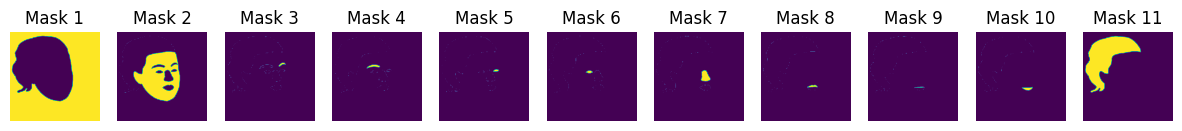

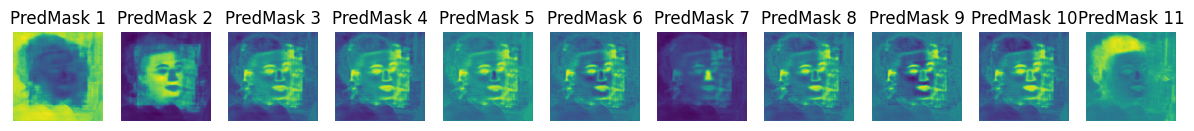

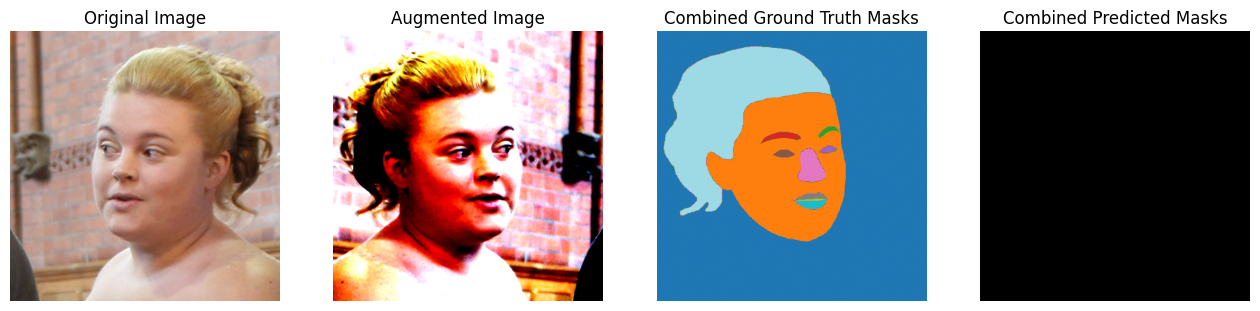

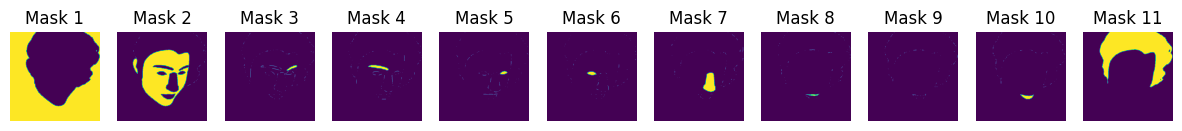

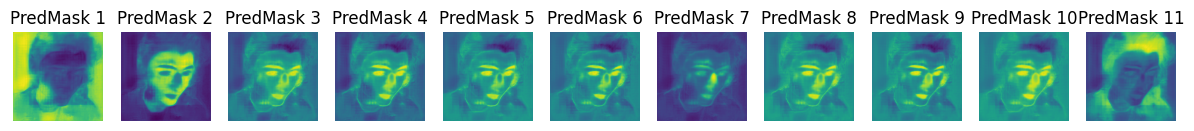

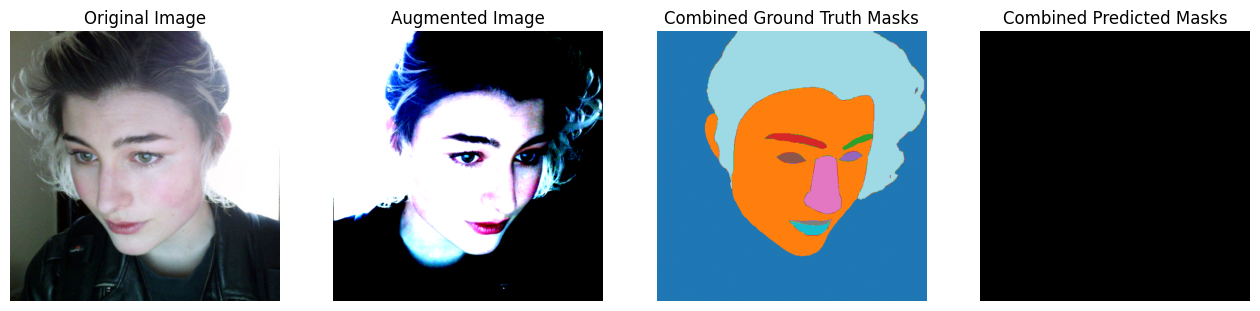

  0%|          | 0/105 [00:08<?, ?it/s]


RuntimeError: CUDA error: device-side assert triggered
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [25]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

avg_iou, avg_dice, cm = test_loop(model, test_loader, nn.BCELoss(), device)